# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix, future, 
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, 
               EnsDb.Hsapiens.v86, 
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [4]:
# Load genome
#suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
#genome(annotations) <- 'hg38'
#seqlevelsStyle(annotations) <- 'UCSC'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")

# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

# Seq info downloaded from: https://github.com/broadinstitute/ichorCNA/issues/84
seq.info = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/seqinfo_hg38_ucsc.rds")

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 4)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)
options(scipen = 999)

In [6]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/"
assets.dir = "/nfs/lab/projects/mega_heart/Assets/"

reference.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds"

In [7]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_5.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = c("Muscular", "Vascular", "Neuro", "Stromal", "Immune"))

cell.compartment = cell.markers[,-3]

In [8]:
cell.markers$CellType = factor(cell.markers$CellType,
                        levels = c("aCM", "vCM",                                   
                                   "SM", "Pericyte",
                                   "Endothelial","Endocardial", "Epicardial", 
                                   "Neuronal", "Fibroblast", "Adipocyte", 'Lymphoid', 'Myeloid'))


In [9]:
log_open(file_name = paste0(base.dir, "Metadata_label.log"))

[1] "/nfs/lab/projects/mega_heart/log/Metadata_label.log"

# UMAP plots

In [10]:
colors.use = c("cadetblue4", "salmon", "lightgoldenrod", 
    "paleturquoise3","palegreen3", "mediumpurple1", 
    "lightblue4", "navajowhite1", "magenta", "coral2", 
    "mediumorchid1", "midnightblue", "lightgoldenrodyellow", 
    "black", "lightgrey", "mistyrose4","darkcyan", "steelblue2", 
    "darkolivegreen3", "mediumpurple1", "lightskyblue", "firebrick2",
    "burlywood", "chartreuse1", "deeppink2", "khaki", "powderblue",
    "slategrey", "springgreen", "yellow3", "orange2", "lightsteelblue3", 
    "tomato3", "palegreen4", "grey27", "darkseagreen", "blue", "darkorchid",
    "snow2", "peachpuff2", "magenta2", "yellowgreen", "cornflowerblue",
    "chocolate", "blueviolet", "lighblue1", "plum2")

In [11]:
in.dir = reference.dir

In [12]:
log_print(" Loading data")
adata = readRDS(in.dir)
log_print(paste("Done"))

[1] " Loading data"
[1] "Done"


In [13]:
adata

An object of class Seurat 
392885 features across 329255 samples within 4 assays 
Active assay: ATAC (285873 features, 285873 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [14]:
# CHECK NUMBER OF PEAKS IN THIS OBJECT

In [643]:
write.table(adata@meta.data, 
            file = paste0("/nfs/lab/projects/mega_heart/Assets/", 'Multiome_metadata.txt'),
            quote = FALSE, col.names = TRUE, row.names = TRUE, sep = "\t")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



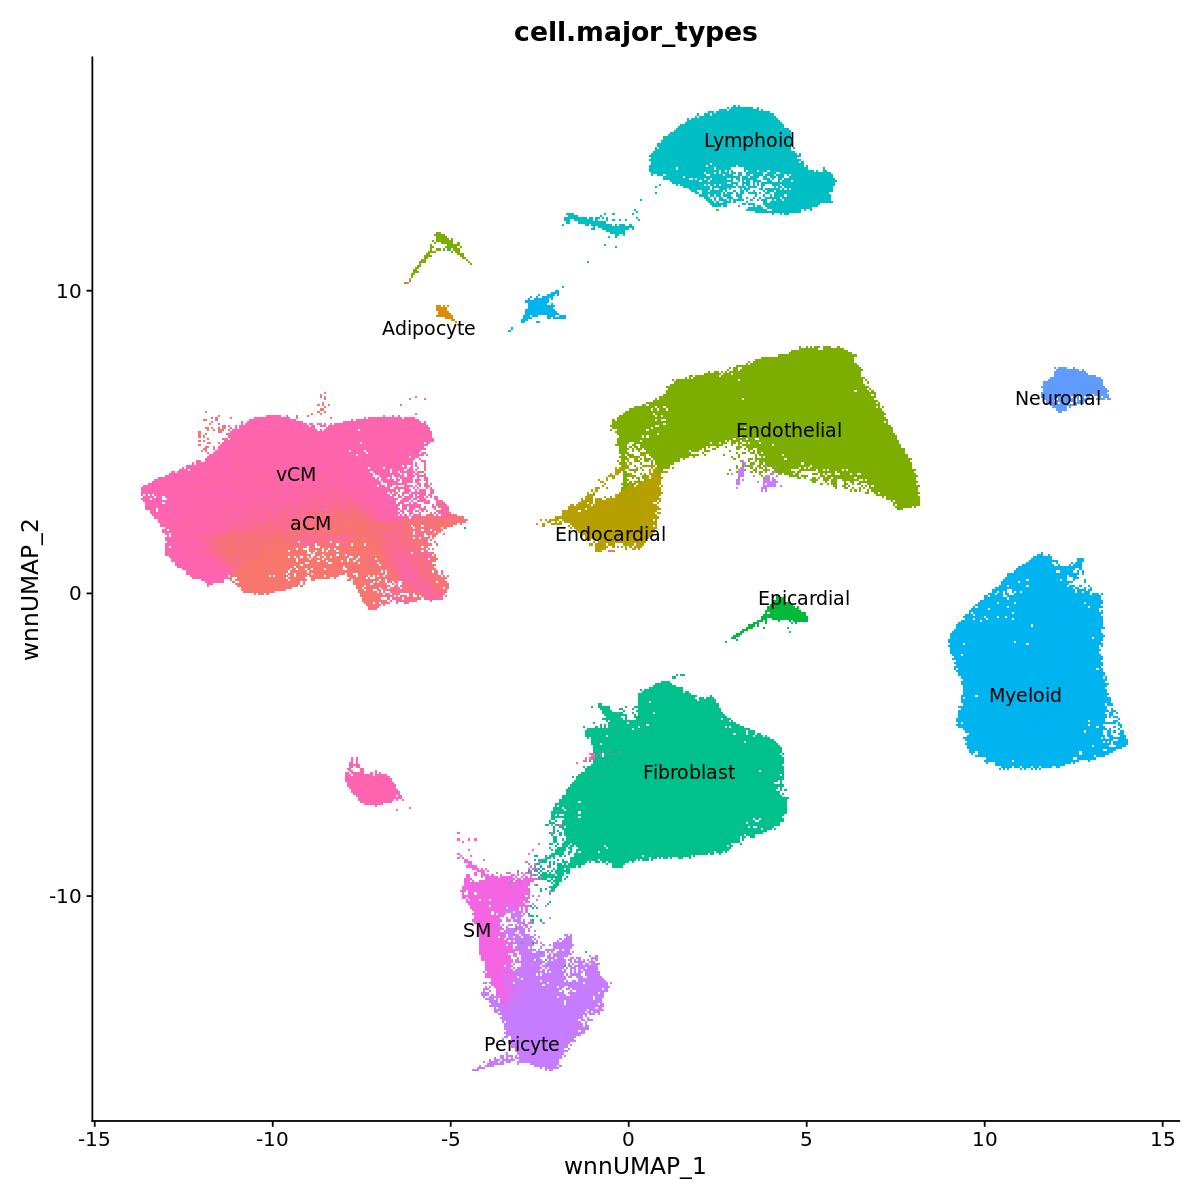

In [17]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn',
        group.by = 'cell.major_types', label=TRUE, repel=TRUE, order = FALSE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



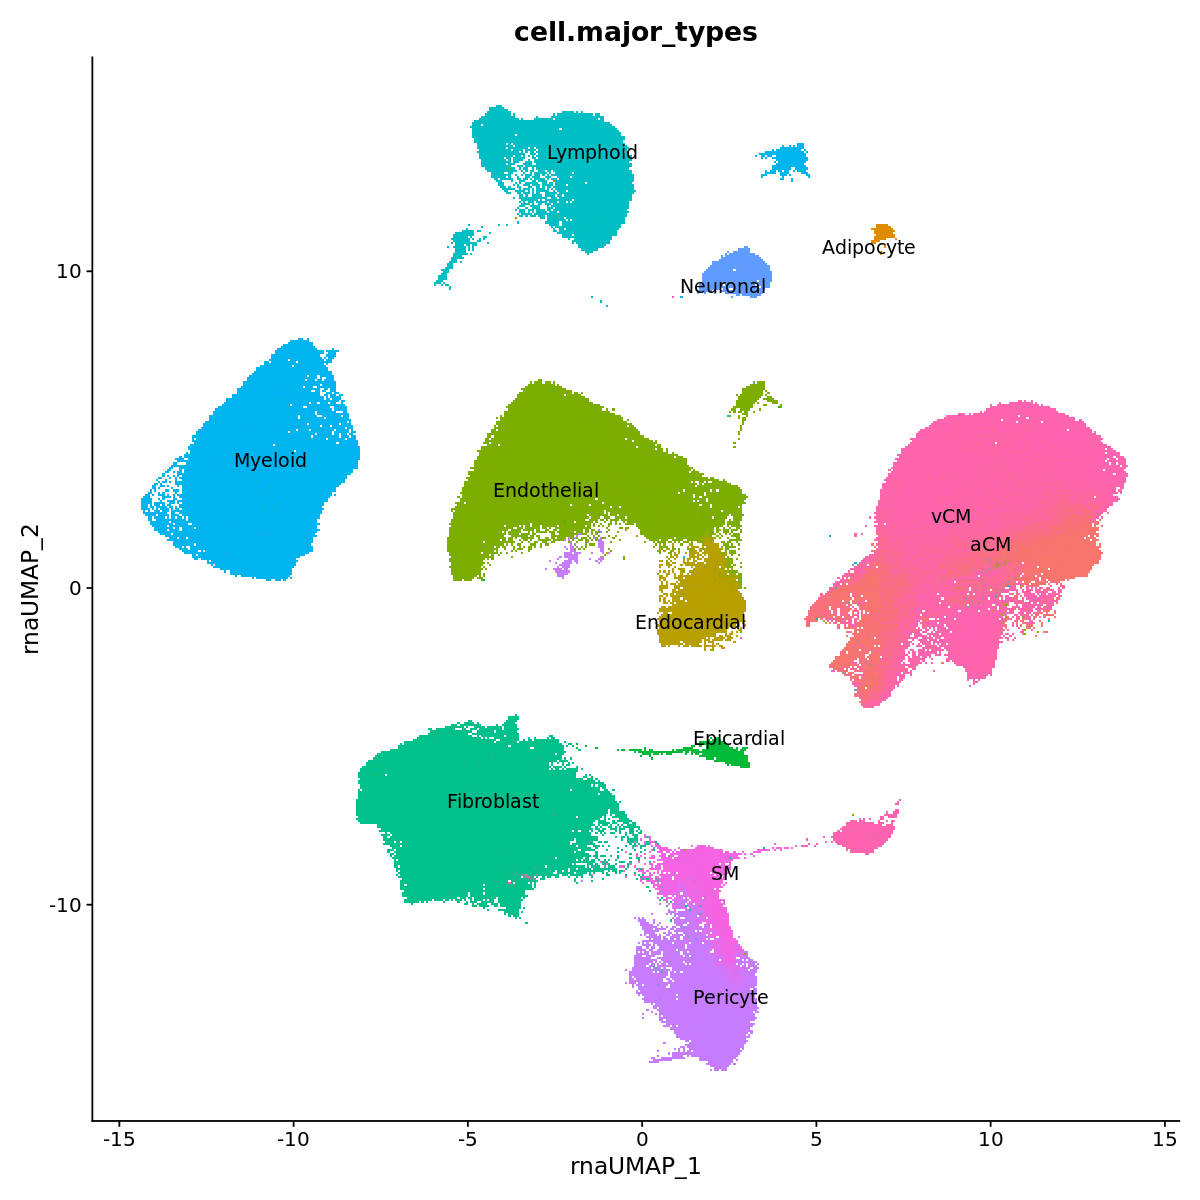

In [16]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.rna',
        group.by = 'cell.major_types', label=TRUE, repel=TRUE, order = FALSE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



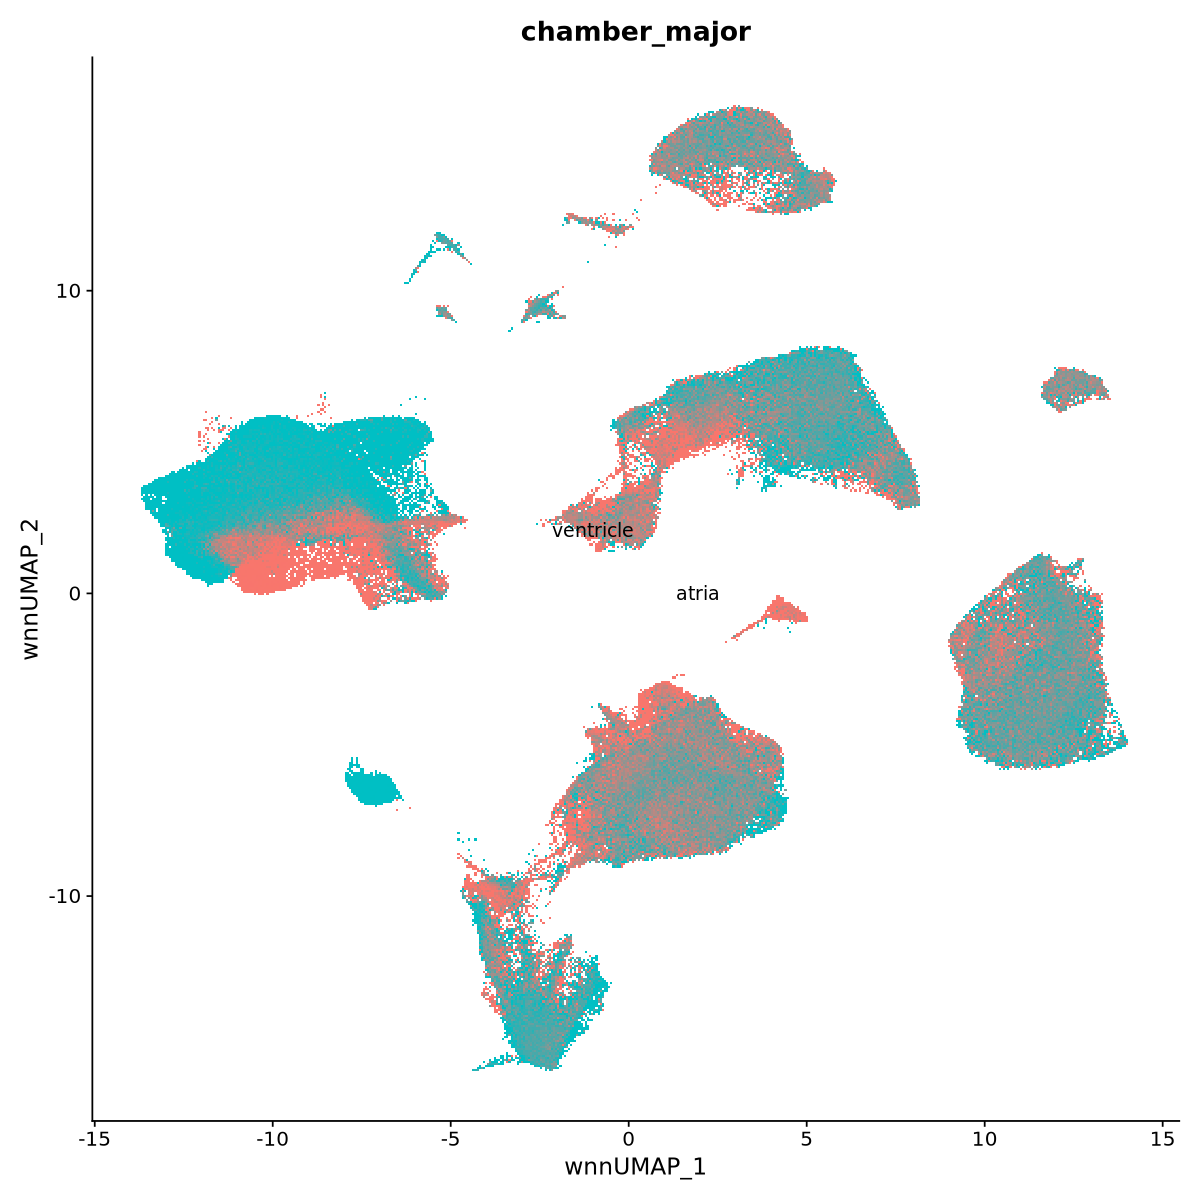

In [15]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'chamber_major', label=TRUE, repel=TRUE, order = TRUE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



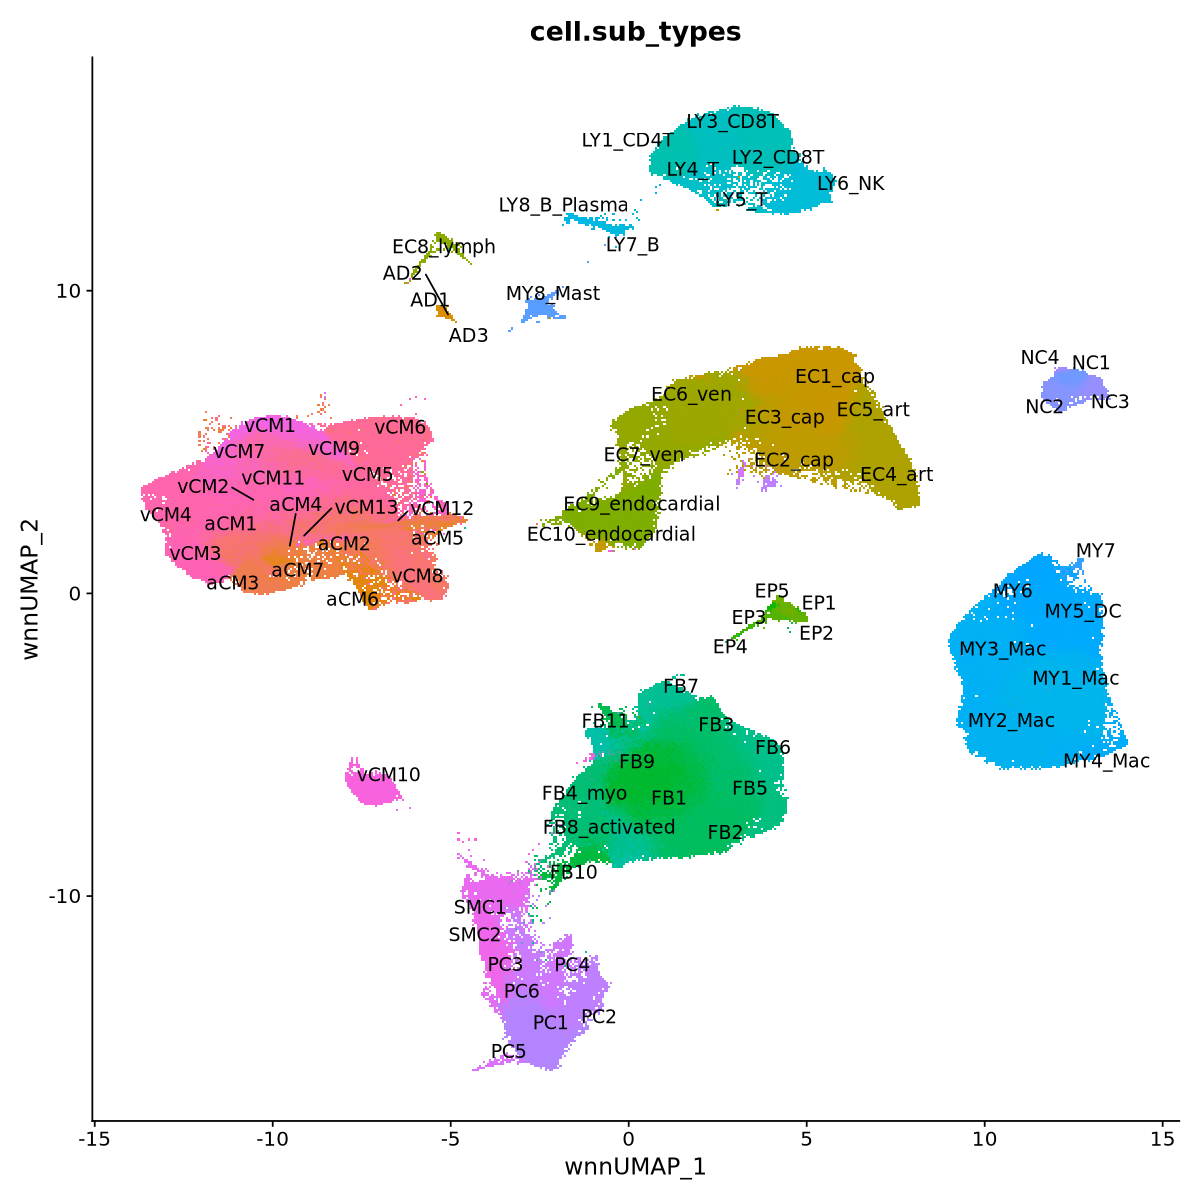

In [16]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn',
        group.by = 'cell.sub_types', label=TRUE, repel=TRUE, order = FALSE) + NoLegend()

# DOT PLOTS

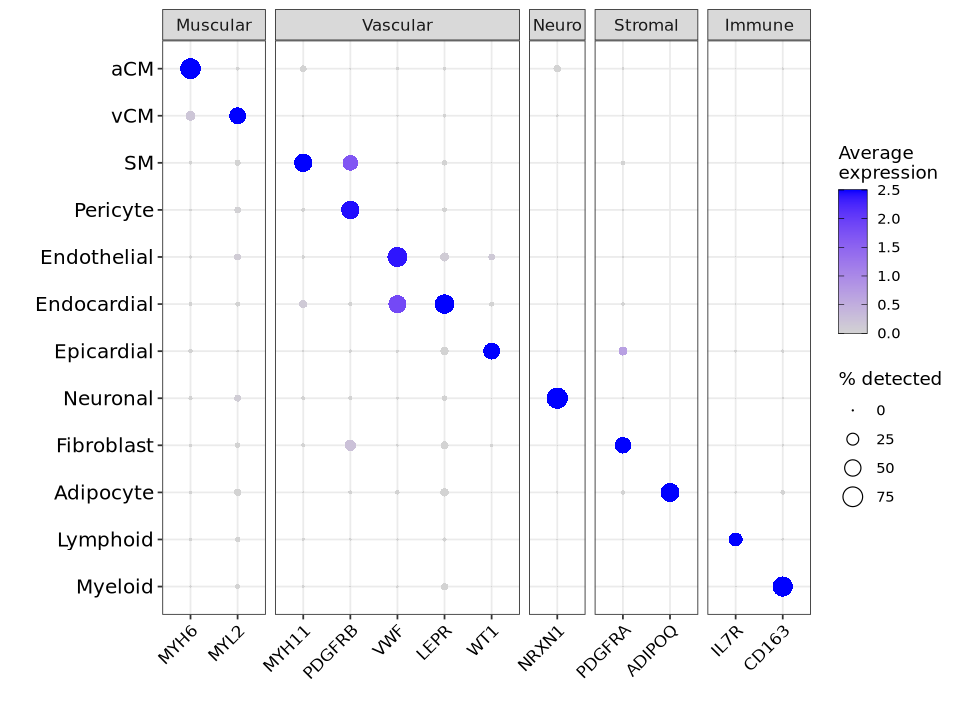

In [449]:
adata <- SetIdent(adata, value = adata$cell.major_types)
g = DotPlot(adata, assay='SCT', features=c("MYH6", "MYL2", "MYH11", "PDGFRB", "VWF", "LEPR", "WT1", "NRXN1", "PDGFRA", "ADIPOQ", "IL7R", "CD163"), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

meta_summary$id = factor(meta_summary$id, levels = rev(levels(cell.markers$CellType)))

    options(repr.plot.width=8, repr.plot.height=6)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment), scales = "free", space = "free")
figure

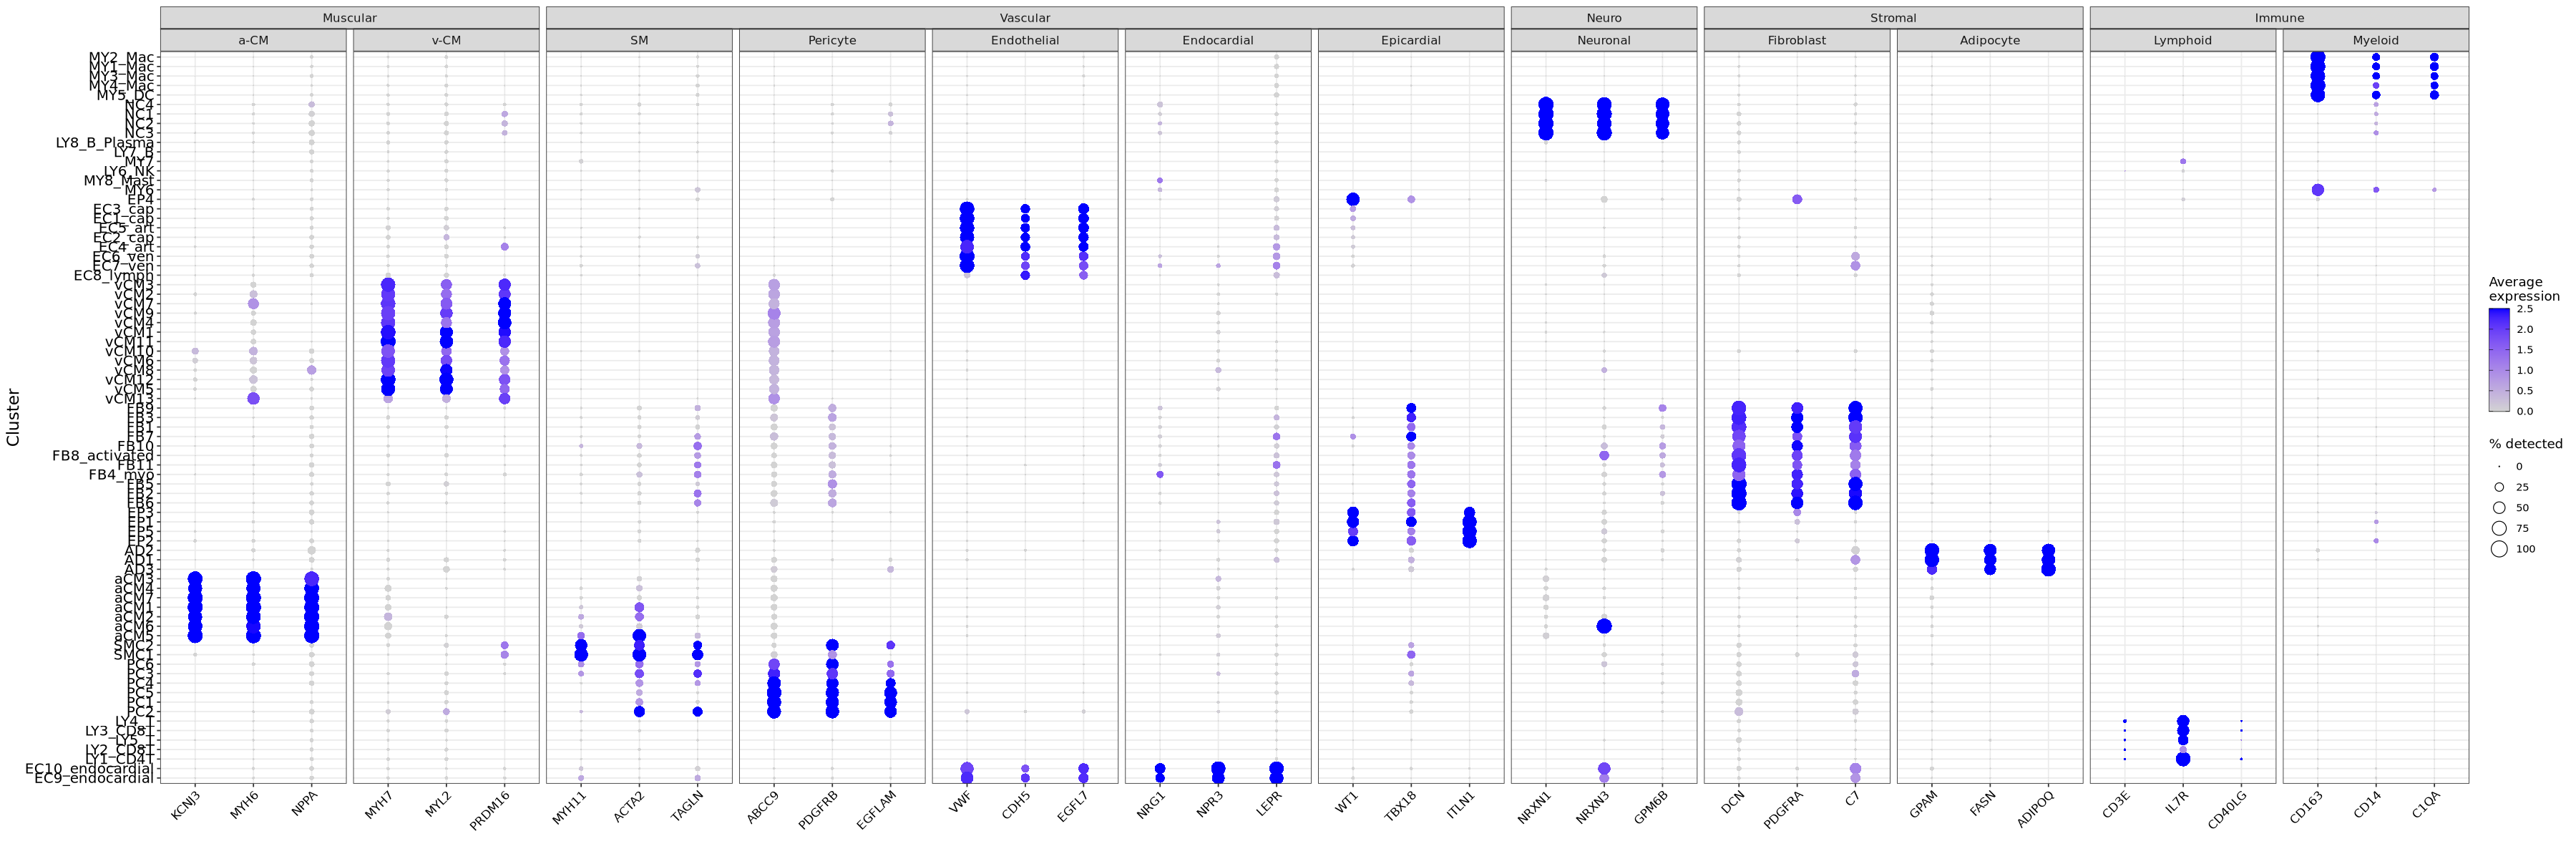

In [46]:
adata <- SetIdent(adata, value = adata$cell.sub_types)
g = DotPlot(adata, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [461]:
write.table(as.data.frame(table(adata$biosample)),
            file = paste0("/nfs/lab/projects/mega_heart/Assets/", 'Multiome_BioSample_Cellnumber.txt'),
            quote = FALSE, col.names = TRUE, row.names = TRUE, sep = "\t")

# Cell Proportions

In [689]:
# Grep cluster order
clusters = rev(levels(cell.markers$CellType))

In [455]:
colors <- c("#33a02c", "#ff7f00", "#e31a1c", "#1f78b4", "#6a3d9a")

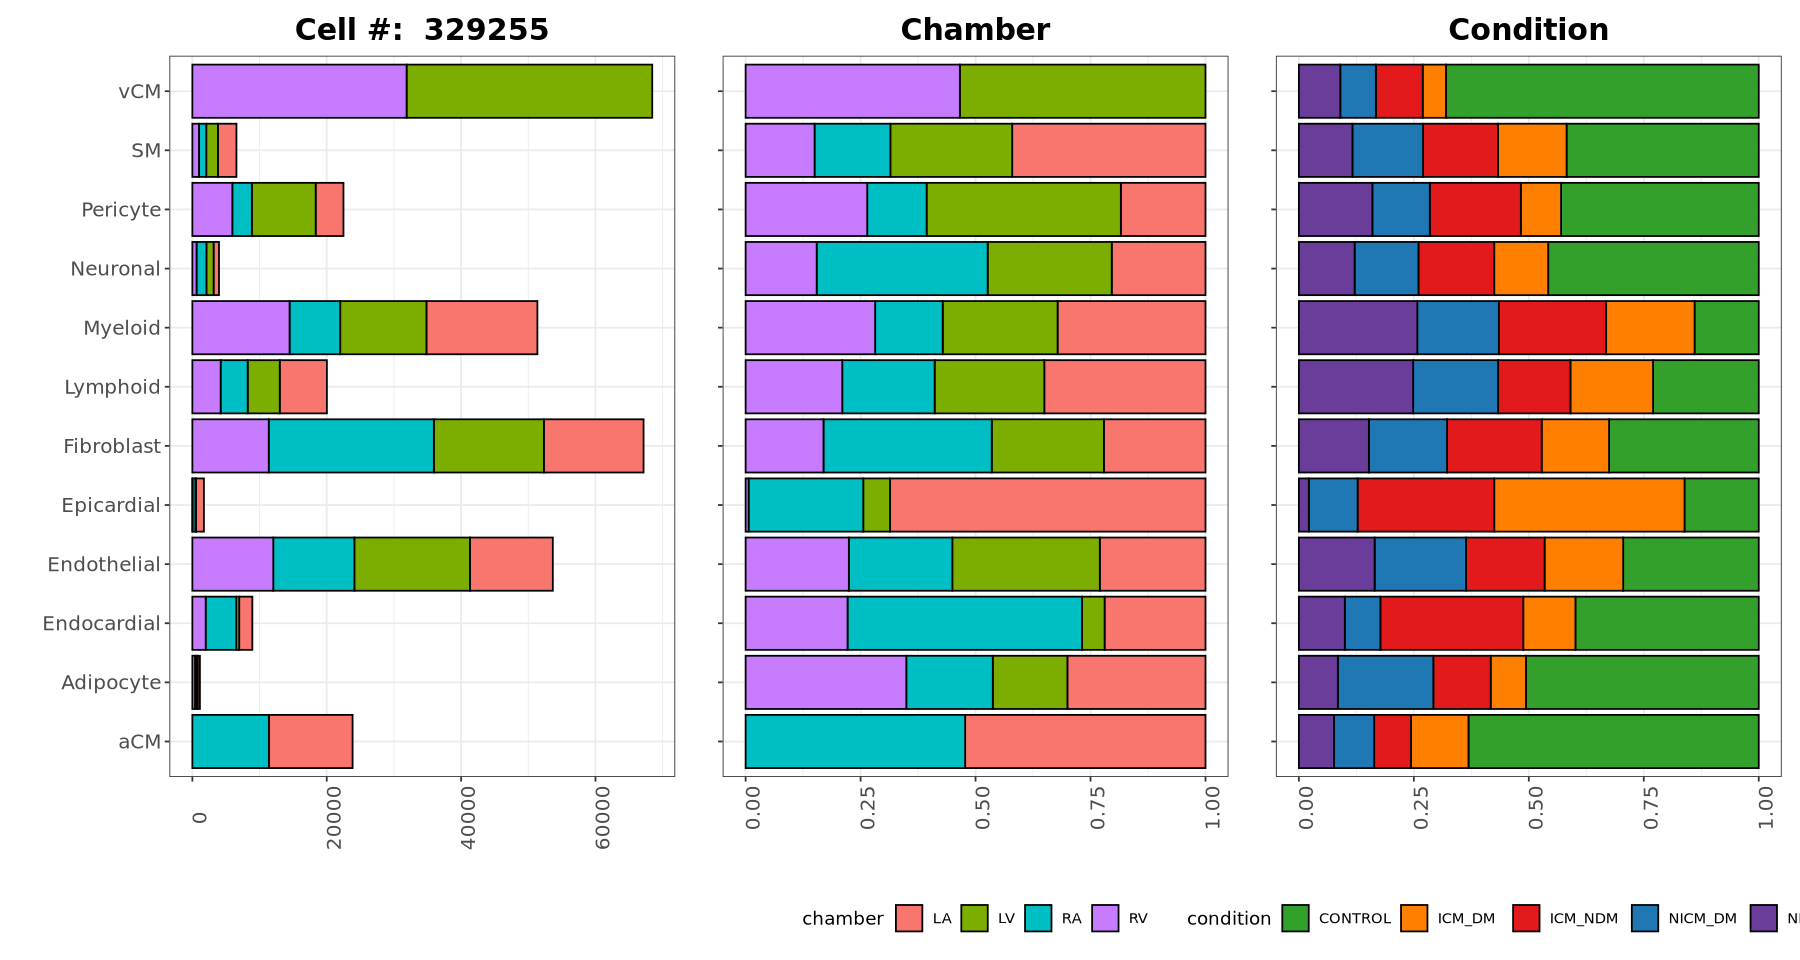

In [457]:
cell.sample = as.data.frame(table(adata$cell.major_types, adata$chamber))
colnames(cell.sample)[1] = "cell.major_types"
colnames(cell.sample)[2] = "chamber"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$seurat_clusters = factor(cell.sample$cell.major_types, levels = clusters)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = cell.major_types, y = Freq, fill = chamber, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= cell.major_types, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Chamber")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank(), legend.position = "bottom" )+
            coord_flip()

# Proportions by condition
cell.sample = as.data.frame(table(adata$cell.major_types, adata$disease_status_sub))
colnames(cell.sample)[1] = "cell.major_types"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)
cell.sample$cluster_celltype = factor(cell.sample$cell.major_types, levels = clusters)

gg3 = ggplot(cell.sample, aes(x= cell.major_types, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Condition")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank(), legend.position = "bottom")+
            coord_flip()+
  scale_fill_manual(values = colors)


options(repr.plot.width=15, repr.plot.height=8)
gg1 + gg2 + gg3

comparing from: aCM to vCM



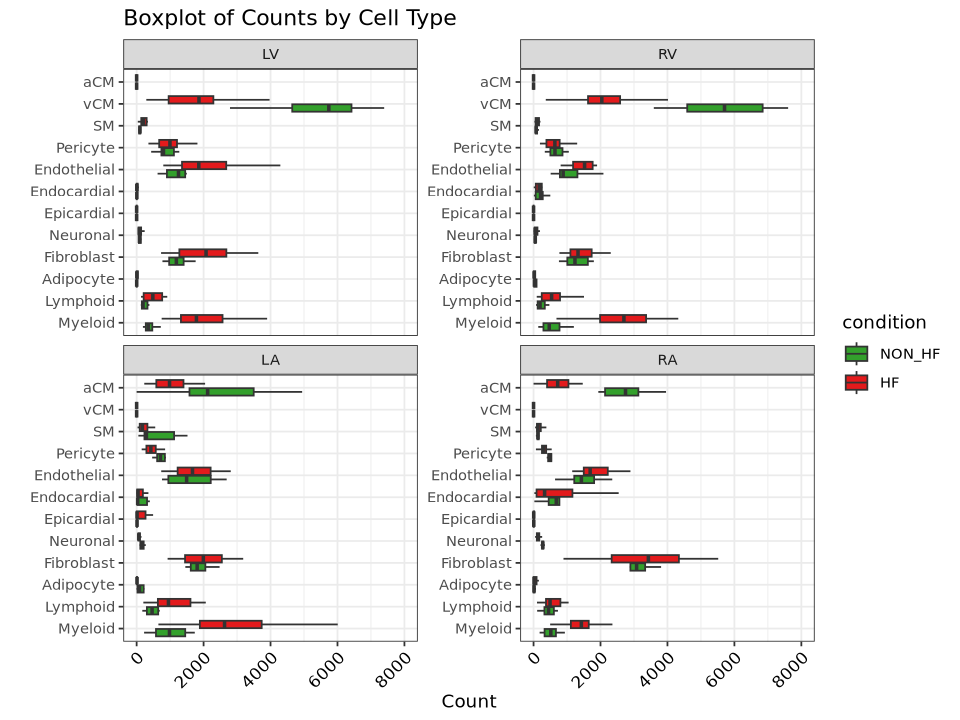

In [684]:
meta = as.data.frame(table(adata$disease_status_major, adata$cell.major_types, adata$biosample))
colnames(meta) = c("condition", "celltype", "donor", "Freq")

# Setup variables
cell_types <- unique(meta$celltype)

# Setup for normalization 
normalizer = 10000

# Convert the 'meta' data from long to wide format
meta_wide <- pivot_wider(meta, 
                         names_from = celltype, 
                         values_from = Freq, 
                         id_cols = c(condition, donor))

# Filter out iteration of wrong donor/condition
meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])


# Define columns to compare
first.celltype = colnames(meta_wide[3])
last.celltype = colnames(meta_wide[ncol(meta_wide)])
message("comparing from: ", first.celltype, " to ", last.celltype)

# Normalize all celltypes by normalizer
cell.proportions = meta_wide %>%
    dplyr::select(donor, condition, cell_types) %>%
    dplyr::rowwise() %>%
    dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype)), 
                  multiplier = normalizer / total_count) %>% 
    dplyr::mutate(across(first.celltype:last.celltype, ~ .x * multiplier))

cell.proportions = dplyr::mutate(cell.proportions, 
                  chamber = str_split_fixed(donor, "--", n = 2)[,1],
                  donor = str_split_fixed(donor, "--", n = 2)[,2])

plot.data = cell.proportions %>%
    dplyr::select(donor, chamber, condition, cell_types) %>%
    pivot_longer(cols = cell_types, 
            names_to = "celltype", 
            values_to = "count")
plot.data$condition = factor(plot.data$condition, levels = c("NON_HF", "HF"))

plot.data$celltype = factor(plot.data$celltype, 
                                      levels = rev(levels(cell.markers$CellType)))
plot.data$chamber = factor(plot.data$chamber, 
                                      levels = c("LV", "RV", "LA", "RA"))


plot = ggplot(plot.data, aes(x = celltype, y = count, fill = condition)) + 
  geom_boxplot(outlier.shape = NA) +
  theme_bw() +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black")) + 
  labs(x = "", y = "Count", title = "Boxplot of Counts by Cell Type") +
  facet_wrap(~chamber, scales = "free_y",  ncol = 2)+
  scale_fill_manual(values = c("NON_HF" = "#33a02c", "HF" = "#e31a1c"))+
  ylim(0, 8000) + 
  coord_flip()
plot

ggsave(plot = plot, 
   filename = paste0(cell.proportions.dir, chamber.use, "CellProportions_4chambers_HFnonHF_SCALED.pdf"), 
    device = "pdf", 
    height = 6, width = 8)

comparing from: aCM to vCM



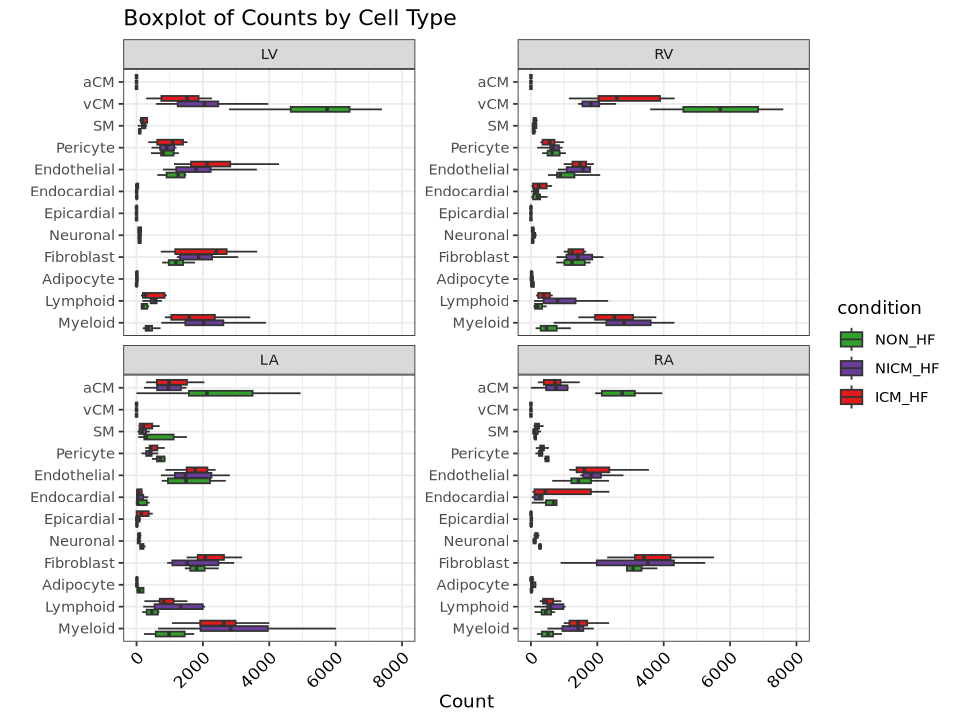

In [687]:
meta = as.data.frame(table(adata$disease_status_sub, adata$cell.major_types, adata$biosample))
colnames(meta) = c("condition", "celltype", "donor", "Freq")

# Setup variables
cell_types <- unique(meta$celltype)

# Setup for normalization 
normalizer = 10000

# Convert the 'meta' data from long to wide format
meta_wide <- pivot_wider(meta, 
                         names_from = celltype, 
                         values_from = Freq, 
                         id_cols = c(condition, donor))

# Filter out iteration of wrong donor/condition
meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])


# Define columns to compare
first.celltype = colnames(meta_wide[3])
last.celltype = colnames(meta_wide[ncol(meta_wide)])
message("comparing from: ", first.celltype, " to ", last.celltype)

# Normalize all celltypes by normalizer
cell.proportions = meta_wide %>%
    dplyr::select(donor, condition, cell_types) %>%
    dplyr::rowwise() %>%
    dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype)), 
                  multiplier = normalizer / total_count) %>% 
    dplyr::mutate(across(first.celltype:last.celltype, ~ .x * multiplier))

cell.proportions = dplyr::mutate(cell.proportions, 
                  chamber = str_split_fixed(donor, "--", n = 2)[,1],
                  donor = str_split_fixed(donor, "--", n = 2)[,2])

plot.data = cell.proportions %>%
    dplyr::select(donor, chamber, condition, cell_types) %>%
    pivot_longer(cols = cell_types, 
            names_to = "celltype", 
            values_to = "count")
plot.data$condition = factor(plot.data$condition, levels = c("NON_HF", "NICM_HF", "ICM_HF"))

plot.data$celltype = factor(plot.data$celltype, 
                                      levels = rev(levels(cell.markers$CellType)))
plot.data$chamber = factor(plot.data$chamber, 
                                      levels = c("LV", "RV", "LA", "RA"))


plot = ggplot(plot.data, aes(x = celltype, y = count, fill = condition)) + 
  geom_boxplot(outlier.shape = NA) +
  theme_bw() +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black")) + 
  labs(x = "", y = "Count", title = "Boxplot of Counts by Cell Type") +
  facet_wrap(~chamber, scales = "free_y",  ncol = 2)+
  scale_fill_manual(values = c("NON_HF" = "#33a02c", 
                               "NICM_HF" = "#6a3d9a",
                               'ICM_HF' = "#e31a1c"))+
  ylim(0, 8000) + 
  coord_flip()
plot

ggsave(plot = plot, 
   filename = paste0(cell.proportions.dir, chamber.use, "CellProportions_4chambers_ICM_NICM_SCALED.pdf"), 
    device = "pdf", 
    height = 6, width = 8)

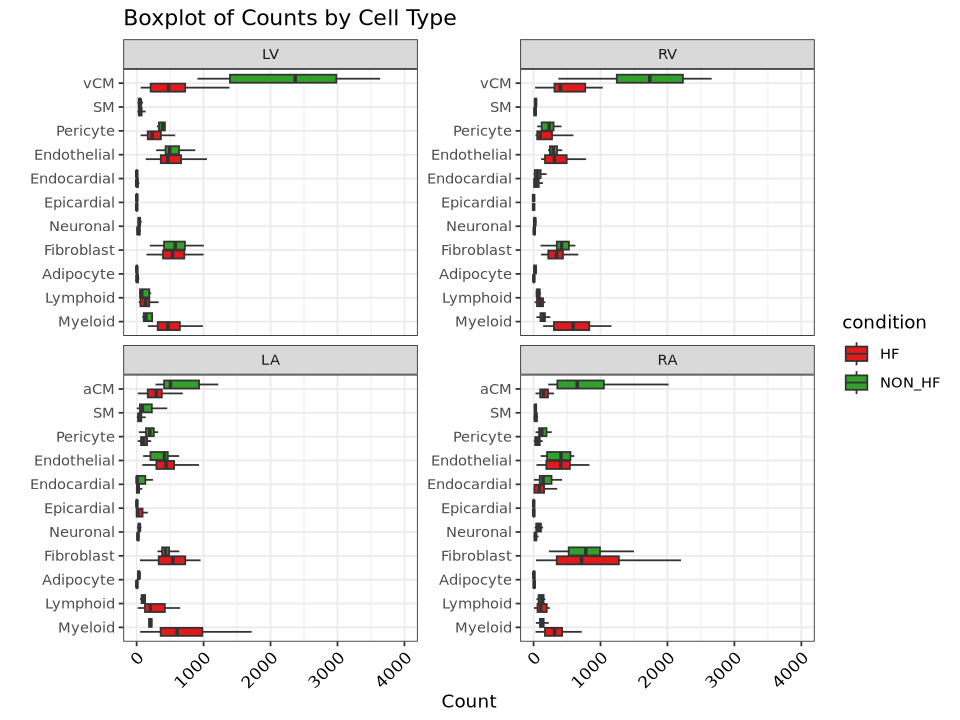

In [676]:
cell.sample = as.data.frame(table(adata$cell.major_types, adata$chamber,
                                  adata$disease_status_major, adata$donor))
colnames(cell.sample)[1] = "cell.major_types"
colnames(cell.sample)[2] = "chamber"
colnames(cell.sample)[3] = "condition"
colnames(cell.sample)[4] = "donor"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$cell.major_types = factor(cell.sample$cell.major_types, 
                                      levels = rev(levels(cell.markers$CellType)))
cell.sample$chamber = factor(cell.sample$chamber, 
                                      levels = c("LV", "RV", "LA", "RA"))

options(repr.plot.width=8, repr.plot.height=6)
plot = ggplot(cell.sample, aes(x = cell.major_types, y = Freq, fill = condition)) + 
  geom_boxplot(outlier.shape = NA) +
  theme_bw() +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black")) + 
  labs(x = "", y = "Count", title = "Boxplot of Counts by Cell Type") +
  facet_wrap(~chamber, scales = "free_y",  ncol = 2)+
  scale_fill_manual(values = c("NON_HF" = "#33a02c", "HF" = "#e31a1c"))+
  ylim(0, 4000) + 
  coord_flip()
plot

ggsave(plot = plot, 
   filename = paste0(cell.proportions.dir, chamber.use, "CellProportions_4chambers_HFnonHF.pdf"), 
    device = "pdf", 
    height = 6, width = 8)

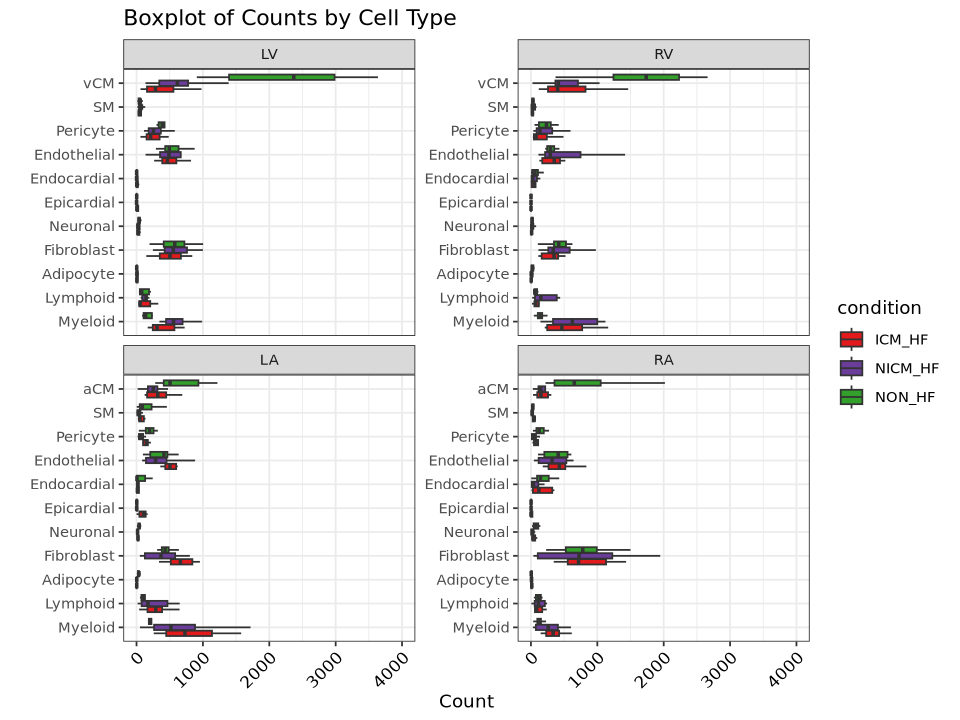

In [641]:
cell.sample = as.data.frame(table(adata$cell.major_types, adata$chamber,
                                  adata$disease_status_sub, adata$donor))
colnames(cell.sample)[1] = "cell.major_types"
colnames(cell.sample)[2] = "chamber"
colnames(cell.sample)[3] = "condition"
colnames(cell.sample)[4] = "donor"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$cell.major_types = factor(cell.sample$cell.major_types, 
                                      levels = rev(levels(cell.markers$CellType)))
cell.sample$chamber = factor(cell.sample$chamber, 
                                      levels = c("LV", "RV", "LA", "RA"))

options(repr.plot.width=8, repr.plot.height=6)
plot = ggplot(cell.sample, aes(x = cell.major_types, y = Freq, fill = condition)) + 
  geom_boxplot(outlier.shape = NA) +
  theme_bw() +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black")) + 
  labs(x = "", y = "Count", title = "Boxplot of Counts by Cell Type") +
  facet_wrap(~chamber, scales = "free_y",  ncol = 2)+
  scale_fill_manual(values = c("NON_HF" = "#33a02c", 
                               "NICM_HF" = "#6a3d9a",
                               'ICM_HF' = "#e31a1c"))+
  ylim(0, 4000) + 
  coord_flip()
plot

ggsave(plot = plot, 
   filename = paste0(cell.proportions.dir, chamber.use, "CellProportions_4chambers_ICM_NICM.pdf"), 
    device = "pdf", 
    height = 6, width = 8)

# Changes in cell proportions - CellSubTypes

In [288]:
cell.proportions.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Cell_Subtypes/CellProportions/"
dir.create(cell.proportions.dir)

In [289]:
adata$biosample = paste0(adata$chamber, "--", adata$donor)

In [290]:
meta = as.data.frame(table(adata$condition, adata$cell.sub_types, adata$biosample))
colnames(meta) = c("condition", "celltype", "donor", "Freq")

In [291]:
unique(meta$condition)

[1] CONTROL  ICM_DM   ICM_NDM  NICM_DM  NICM_NDM
Levels: CONTROL ICM_DM  ICM_NDM NICM_DM NICM_NDM

In [292]:
# Setup variables
cell_types <- unique(meta$celltype)

# Setup conditions
disease.ls = c("ICM_NDM", "ICM_DM ", "NICM_NDM", "NICM_DM")
control.ls = c("CONTROL", "CONTROL", "CONTROL", "CONTROL")

contrast.ls = as.vector(paste0(disease.ls, "-Vs-", control.ls))

# Setup for normalization 
normalizer = 10000

In [293]:
# Convert the 'meta' data from long to wide format
meta_wide <- pivot_wider(meta, 
                         names_from = celltype, 
                         values_from = Freq, 
                         id_cols = c(condition, donor))

# Filter out iteration of wrong donor/condition
meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])

In [296]:
# Define columns to compare
first.celltype = colnames(meta_wide[3])
last.celltype = colnames(meta_wide[ncol(meta_wide)])
message("comparing from: ", first.celltype, " to ", last.celltype)

# Normalize all celltypes by normalizer
cell.proportions = meta_wide %>%
    dplyr::select(donor, condition, cell_types) %>%
    dplyr::rowwise() %>%
    dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype)), 
                  multiplier = normalizer / total_count) %>% 
    dplyr::mutate(across(first.celltype:last.celltype, ~ .x * multiplier))

cell.proportions = dplyr::mutate(cell.proportions, 
                  chamber = str_split_fixed(donor, "--", n = 2)[,1])

comparing from: aCM1 to vCM9



In [317]:
# Initialize two empty dataframes: one for t-tests and one for ANOVA
t_test_results <- data.frame(
  CellType = character(),
  comparison = character(),
  TStatistic = numeric(),
  PValue = numeric(),
  MeanDISEASE = numeric(),
  MeanCONTROL = numeric(),
  stringsAsFactors = FALSE
)

for (i in seq_along(contrast.ls)){
    contrast = contrast.ls[i]
    message("  Processing :", contrast)
    disease = disease.ls[i]
    control = control.ls[i]
    
    for (cell_type in cell_types) {
        message("  Analyzing :", cell_type)
        
        # Extract values for Disease and CONTROL for this cell type
        disease_values <- cell.proportions %>%
                          dplyr::filter(condition == disease) %>%
                          dplyr::select(!!sym(cell_type)) %>% unlist()
                          
        control_values <- cell.proportions %>%
                          dplyr::filter(condition == control) %>%
                          dplyr::select(!!sym(cell_type)) %>% unlist()

        # Calculate means
        MeanDISEASE = mean(disease_values, na.rm = TRUE)
        MeanCONTROL = mean(control_values, na.rm = TRUE)
        
        message("  Max cell count :", max(c(disease_values, control_values)))
        
        # Run paired t-test
        t_test_result <- t.test(disease_values, control_values)
        
        # Store t-test results
        t_test_results <- rbind(t_test_results, data.frame(
            CellType = cell_type,
            comparison = contrast, 
            TStatistic = t_test_result$statistic,
            PValue = t_test_result$p.value,
            MeanDISEASE = MeanDISEASE,
            MeanCONTROL = MeanCONTROL
        ))
    }
}

  Processing :ICM_NDM-Vs-CONTROL

  Analyzing :aCM1

  Max cell count :4359.82079698184

  Analyzing :aCM2

  Max cell count :1691.35802469136

  Analyzing :aCM3

  Max cell count :3520.29809766621

  Analyzing :aCM4

  Max cell count :1348.41628959276

  Analyzing :aCM5

  Max cell count :2612.3492875411

  Analyzing :aCM6

  Max cell count :64.1482537419815

  Analyzing :aCM7

  Max cell count :133.951571354972

  Analyzing :AD1

  Max cell count :635.73883161512

  Analyzing :AD2

  Max cell count :15.8982511923688

  Analyzing :AD3

  Max cell count :3.17965023847377

  Analyzing :EC1_cap

  Max cell count :1683.95363026236

  Analyzing :EC10_endocardial

  Max cell count :133.868808567604

  Analyzing :EC2_cap

  Max cell count :1550.19059720457

  Analyzing :EC3_cap

  Max cell count :152.957171991842

  Analyzing :EC4_art

  Max cell count :689.444783404515

  Analyzing :EC5_art

  Max cell count :91.1854103343465

  Analyzing :EC6_ven

  Max cell count :1225.16556291391

  Anal

  Analyzing :vCM2

  Max cell count :4200.47732696897

  Analyzing :vCM3

  Max cell count :6860.07813630444

  Analyzing :vCM4

  Max cell count :5822.85303629177

  Analyzing :vCM5

  Max cell count :953.196347031963

  Analyzing :vCM6

  Max cell count :1949.06953966699

  Analyzing :vCM7

  Max cell count :4350.90333395418

  Analyzing :vCM8

  Max cell count :928.217821782178

  Analyzing :vCM9

  Max cell count :4981.34328358209

  Processing :NICM_NDM-Vs-CONTROL

  Analyzing :aCM1

  Max cell count :4359.82079698184

  Analyzing :aCM2

  Max cell count :844.919786096257

  Analyzing :aCM3

  Max cell count :3520.29809766621

  Analyzing :aCM4

  Max cell count :1348.41628959276

  Analyzing :aCM5

  Max cell count :2612.3492875411

  Analyzing :aCM6

  Max cell count :85.3889943074004

  Analyzing :aCM7

  Max cell count :4850

  Analyzing :AD1

  Max cell count :635.73883161512

  Analyzing :AD2

  Max cell count :21.3675213675214

  Analyzing :AD3

  Max cell count :3.26904217

  Analyzing :PC6

  Max cell count :26.6951414842499

  Analyzing :SMC1

  Max cell count :1349.73404255319

  Analyzing :SMC2

  Max cell count :435.875943000838

  Analyzing :vCM1

  Max cell count :6542.14794789875

  Analyzing :vCM10

  Max cell count :1330.92078809811

  Analyzing :vCM11

  Max cell count :3172.23198594025

  Analyzing :vCM12

  Max cell count :552.123552123552

  Analyzing :vCM13

  Max cell count :692.978430472694

  Analyzing :vCM2

  Max cell count :3204.57796852647

  Analyzing :vCM3

  Max cell count :6860.07813630444

  Analyzing :vCM4

  Max cell count :5822.85303629177

  Analyzing :vCM5

  Max cell count :930.40293040293

  Analyzing :vCM6

  Max cell count :900.683554483313

  Analyzing :vCM7

  Max cell count :4350.90333395418

  Analyzing :vCM8

  Max cell count :803.807509254363

  Analyzing :vCM9

  Max cell count :4981.34328358209



In [318]:
# Initialize dataframe for ANOVA results with additional columns for the main effects and interaction
anova_results <- data.frame(
  CellType = character(),
  Chamber_PValue = numeric(),
  Condition_PValue = numeric(),
  Interaction_PValue = numeric(),
  stringsAsFactors = FALSE
)


# Run ANOVA for all conditions and chambers for each cell type
for (cell_type in cell_types) {
    message("Running ANOVA for cell type:", cell_type)
    
    # Perform ANOVA with both chamber and condition, including interaction
    anova_result <- aov(as.formula(paste(cell_type, "~ chamber * condition")), data = cell.proportions)
    
    # Extract the p-values for chamber, condition, and interaction
    anova_summary <- summary(anova_result)
    
    # Extract the p-values for chamber, condition, and interaction
    chamber_p_value <- anova_summary[[1]]$`Pr(>F)`[1]  # P-value for chamber
    condition_p_value <- anova_summary[[1]]$`Pr(>F)`[2]  # P-value for condition
    interaction_p_value <- anova_summary[[1]]$`Pr(>F)`[3]  # P-value for chamber:condition interaction
    
    # Store the results
    anova_results <- rbind(anova_results, data.frame(
        CellType = cell_type,
        Chamber_PValue = chamber_p_value,
        Condition_PValue = condition_p_value,
        Interaction_PValue = interaction_p_value
    ))
}


Running ANOVA for cell type:aCM1

Running ANOVA for cell type:aCM2

Running ANOVA for cell type:aCM3

Running ANOVA for cell type:aCM4

Running ANOVA for cell type:aCM5

Running ANOVA for cell type:aCM6

Running ANOVA for cell type:aCM7

Running ANOVA for cell type:AD1

Running ANOVA for cell type:AD2

Running ANOVA for cell type:AD3

Running ANOVA for cell type:EC1_cap

Running ANOVA for cell type:EC10_endocardial

Running ANOVA for cell type:EC2_cap

Running ANOVA for cell type:EC3_cap

Running ANOVA for cell type:EC4_art

Running ANOVA for cell type:EC5_art

Running ANOVA for cell type:EC6_ven

Running ANOVA for cell type:EC7_ven

Running ANOVA for cell type:EC8_lymph

Running ANOVA for cell type:EC9_endocardial

Running ANOVA for cell type:EP1

Running ANOVA for cell type:EP2

Running ANOVA for cell type:EP3

Running ANOVA for cell type:EP4

Running ANOVA for cell type:EP5

Running ANOVA for cell type:FB1

Running ANOVA for cell type:FB10

Running ANOVA for cell type:FB11

Running 

In [319]:
# Create Lineage column
major.minor = as.data.frame(table(adata$cell.major_types, adata$cell.sub_types))
major.minor = dplyr::filter(major.minor, Freq != 0)
major.minor = dplyr::select(major.minor, -Freq)
colnames(major.minor) = c("Lineage", "CellType")

## Print T-test results

In [320]:
# Merge results
results = merge(t_test_results, major.minor, by = "CellType")

# add FDR correction
results = results %>%
    dplyr::mutate(FDR = round(p.adjust(PValue, method = "BH"), digits = 4))

# counting stars
results$stars = results$FDR
results$stars[results$FDR > 0.1] <- ""
results$stars[results$FDR <= 0.01] <- "***"
results$stars[results$FDR <= 0.05 & results$FDR > 0.01] <- "**"
results$stars[results$FDR <= 0.1 & results$FDR > 0.05] <- "*"

# Save the consolidated table to a CSV file
file = paste0(cell.proportions.dir, "By_biosample_cellProportions_Ttest.csv")
write.csv(results, file = file, row.names = FALSE) 

In [321]:
dplyr::filter(results, Lineage == "aCM")

CellType,comparison,TStatistic,PValue,MeanDISEASE,MeanCONTROL,Lineage,FDR,stars
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>
aCM1,ICM_NDM-Vs-CONTROL,-2.6868115,0.009936400,87.110587,541.547489,aCM,0.0457,**
aCM1,NICM_DM-Vs-CONTROL,-2.7995627,0.007445049,71.049220,541.547489,aCM,0.0372,**
aCM1,ICM_DM -Vs-CONTROL,-3.1452126,0.003145357,35.457991,541.547489,aCM,0.0209,**
aCM1,NICM_NDM-Vs-CONTROL,-3.1485354,0.003104608,33.996572,541.547489,aCM,0.0209,**
aCM2,NICM_DM-Vs-CONTROL,0.1023506,0.919162461,162.968182,155.212801,aCM,0.9377,
aCM2,ICM_NDM-Vs-CONTROL,0.2582330,0.798304726,179.442837,155.212801,aCM,0.8479,
aCM2,ICM_DM -Vs-CONTROL,0.8277016,0.414382427,217.703180,155.212801,aCM,0.5188,
aCM2,NICM_NDM-Vs-CONTROL,0.4326610,0.667585082,180.748016,155.212801,aCM,0.7370,
aCM3,ICM_NDM-Vs-CONTROL,-2.1059582,0.041654966,11.956519,281.229996,aCM,0.1190,


## Print anova results

In [324]:
# Merge results
results = merge(anova_results, major.minor, by = "CellType")

# add FDR correction
results = results %>%
    dplyr::mutate(FDR = round(p.adjust(Condition_PValue, method = "BH"), digits = 4))

# counting stars
results$stars = results$FDR
results$stars[results$FDR > 0.1] <- ""
results$stars[results$FDR <= 0.01] <- "***"
results$stars[results$FDR <= 0.05 & results$FDR > 0.01] <- "**"
results$stars[results$FDR <= 0.1 & results$FDR > 0.05] <- "*"

# Save the consolidated table to a CSV file
file = paste0(cell.proportions.dir, "By_biosample_cellProportions_Anova.csv")
write.csv(results, file = file, row.names = FALSE) 

In [399]:
dplyr::filter(results, Lineage == "Myeloid")

CellType,Chamber_PValue,Condition_PValue,Interaction_PValue,Lineage,FDR,stars
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>
MY1_Mac,0.0042749668,0.000000008378978,0.5814609,Myeloid,0.0000,***
MY2_Mac,0.0187493966,0.000109826335077,0.2006967,Myeloid,0.0007,***
MY3_Mac,0.2319095388,0.000001185564607,0.9500498,Myeloid,0.0000,***
MY4_Mac,0.1628945386,0.044361386731650,0.6816984,Myeloid,0.0899,*
MY5_DC,0.0001365183,0.000000035941944,0.2727891,Myeloid,0.0000,***
MY6,0.0893477396,0.000110664130760,0.2140411,Myeloid,0.0007,***
MY7,0.0159140915,0.000000205428359,0.1792129,Myeloid,0.0000,***
MY8_Mast,0.0021648351,0.097287126119747,0.5919876,Myeloid,0.1594,


# Changes in cell proportions - Lineages by chamber

In [568]:
cell.proportions.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/CellProportions/"
dir.create(cell.proportions.dir)

In [570]:
chamber.ls = c("LV", "LA", "RV", "RA")

## Diabetes changes

In [572]:
for (i in seq_along(chamber.ls)){
    chamber.use = chamber.ls[i]
    message("Processing: ", chamber.use)
    adata.use = subset(adata, chamber == chamber.use)
    meta = as.data.frame(table(adata.use$condition, adata.use$cell.major_types, adata.use$donor))
    colnames(meta) = c("condition", "celltype", "donor", "Freq")
    message(" - Working on the following conditions: ", paste0(unique(meta$condition), collapse = "|"))
    
    # Setup variables
    cell_types <- unique(meta$celltype)

    # Setup conditions
    disease.ls = c("ICM_NDM", "ICM_DM ", "NICM_NDM", "NICM_DM")
    control.ls = c("CONTROL", "CONTROL", "CONTROL", "CONTROL")

    contrast.ls = as.vector(paste0(disease.ls, "-Vs-", control.ls))

    # Setup for normalization 
    normalizer = 10000
    
    # Convert the 'meta' data from long to wide format
    meta_wide <- pivot_wider(meta, 
                             names_from = celltype, 
                             values_from = Freq, 
                             id_cols = c(condition, donor))

    # Filter out iteration of wrong donor/condition
    meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])
    
    # Define columns to compare
    first.celltype = colnames(meta_wide[3])
    last.celltype = colnames(meta_wide[ncol(meta_wide)])
    message("comparing from: ", first.celltype, " to ", last.celltype)

    # Normalize all celltypes by normalizer
    cell.proportions = meta_wide %>%
        dplyr::select(donor, condition, cell_types) %>%
        dplyr::rowwise() %>%
        dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype)), 
                      multiplier = normalizer / total_count) %>% 
        dplyr::mutate(across(first.celltype:last.celltype, ~ .x * multiplier))

    cell.proportions = dplyr::mutate(cell.proportions, 
                      chamber = str_split_fixed(donor, "--", n = 2)[,1])
    
    # Initialize two empty dataframes: one for t-tests and one for ANOVA
    t_test_results <- data.frame(
      CellType = character(),
      comparison = character(),
      TStatistic = numeric(),
      PValue = numeric(),
      MeanDISEASE = numeric(),
      MeanCONTROL = numeric(),
      stringsAsFactors = FALSE
    )

    for (i in seq_along(contrast.ls)){
        contrast = contrast.ls[i]
        message("  Processing :", contrast)
        disease = disease.ls[i]
        control = control.ls[i]

        for (cell_type in cell_types) {
            message("  Analyzing :", cell_type)

            # Extract values for Disease and CONTROL for this cell type
            disease_values <- cell.proportions %>%
                              dplyr::filter(condition == disease) %>%
                              dplyr::select(!!sym(cell_type)) %>% unlist()

            control_values <- cell.proportions %>%
                              dplyr::filter(condition == control) %>%
                              dplyr::select(!!sym(cell_type)) %>% unlist()

            # Calculate means
            MeanDISEASE = mean(disease_values, na.rm = TRUE)
            MeanCONTROL = mean(control_values, na.rm = TRUE)

            message("  Max cell count :", max(c(disease_values, control_values)))

            # Run paired t-test
            t_test_result <- t.test(disease_values, control_values)

            # Store t-test results
            t_test_results <- rbind(t_test_results, data.frame(
                CellType = cell_type,
                comparison = contrast, 
                TStatistic = t_test_result$statistic,
                PValue = t_test_result$p.value,
                MeanDISEASE = MeanDISEASE,
                MeanCONTROL = MeanCONTROL
            ))
        }
        # Merge results
        results = t_test_results

        # add FDR correction
        results = results %>%
            dplyr::mutate(FDR = round(p.adjust(PValue, method = "BH"), digits = 4))

        # counting stars
        results$stars = results$FDR
        results$stars[results$FDR > 0.1] <- ""
        results$stars[results$FDR <= 0.01] <- "***"
        results$stars[results$FDR <= 0.05 & results$FDR > 0.01] <- "**"
        results$stars[results$FDR <= 0.1 & results$FDR > 0.05] <- "*"

        # Save the consolidated table to a CSV file
        file = paste0(cell.proportions.dir, chamber.use, "_by_donor_cellProportions_Ttest.csv")
        write.csv(results, file = file, row.names = FALSE) 
        
    }
}

Processing: LV

 - Working on the following conditions: CONTROL|ICM_DM |ICM_NDM|NICM_DM|NICM_NDM

comparing from: Adipocyte to vCM

  Processing :ICM_NDM-Vs-CONTROL

  Analyzing :Adipocyte

  Max cell count :168.10168101681

  Analyzing :Endocardial

  Max cell count :203.866432337434

  Analyzing :Endothelial

  Max cell count :2898.41116995667

  Analyzing :Epicardial

  Max cell count :176.662017666202

  Analyzing :Fibroblast

  Max cell count :3634.51776649746

  Analyzing :Lymphoid

  Max cell count :1031.84950642578

  Analyzing :Myeloid

  Max cell count :3426.31334263133

  Analyzing :Neuronal

  Max cell count :319.796954314721

  Analyzing :Pericyte

  Max cell count :1907.24815724816

  Analyzing :SM

  Max cell count :837.56345177665

  Analyzing :vCM

  Max cell count :7394.93733103957

  Processing :ICM_DM -Vs-CONTROL

  Analyzing :Adipocyte

  Max cell count :34.2465753424658

  Analyzing :Endocardial

  Max cell count :203.866432337434

  Analyzing :Endothelial

  Max 

  Analyzing :Lymphoid

  Max cell count :2326.81121099947

  Analyzing :Myeloid

  Max cell count :3289.26493918562

  Analyzing :Neuronal

  Max cell count :274.442538593482

  Analyzing :Pericyte

  Max cell count :1053.17324185249

  Analyzing :SM

  Max cell count :488.963397597094

  Analyzing :vCM

  Max cell count :7605.26696570684

Processing: RA

 - Working on the following conditions: CONTROL|ICM_DM |ICM_NDM|NICM_DM|NICM_NDM

comparing from: aCM to SM

  Processing :ICM_NDM-Vs-CONTROL

  Analyzing :aCM

  Max cell count :3957.63875269661

  Analyzing :Adipocyte

  Max cell count :97.2762645914397

  Analyzing :Endocardial

  Max cell count :2362.78447121821

  Analyzing :Endothelial

  Max cell count :2350.99337748344

  Analyzing :Epicardial

  Max cell count :567.084446270803

  Analyzing :Fibroblast

  Max cell count :5516.74982181041

  Analyzing :Lymphoid

  Max cell count :1402.7149321267

  Analyzing :Myeloid

  Max cell count :2356.09103078983

  Analyzing :Neuronal



## ICM NICM

In [576]:
for (i in seq_along(chamber.ls)){
    chamber.use = chamber.ls[i]
    message("Processing: ", chamber.use)
    adata.use = subset(adata, chamber == chamber.use)
    meta = as.data.frame(table(adata.use$disease_status_sub, adata.use$cell.major_types, adata.use$donor))
    colnames(meta) = c("condition", "celltype", "donor", "Freq")
    message(" - Working on the following conditions: ", paste0(unique(meta$condition), collapse = "|"))
    
    # Setup variables
    cell_types <- unique(meta$celltype)

    # Setup conditions
    disease.ls = c("ICM_HF", "NICM_HF")
    control.ls = c("NON_HF", "NON_HF")

    contrast.ls = as.vector(paste0(disease.ls, "-Vs-", control.ls))

    # Setup for normalization 
    normalizer = 10000
    
    # Convert the 'meta' data from long to wide format
    meta_wide <- pivot_wider(meta, 
                             names_from = celltype, 
                             values_from = Freq, 
                             id_cols = c(condition, donor))

    # Filter out iteration of wrong donor/condition
    meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])
    
    # Define columns to compare
    first.celltype = colnames(meta_wide[3])
    last.celltype = colnames(meta_wide[ncol(meta_wide)])
    message("comparing from: ", first.celltype, " to ", last.celltype)

    # Normalize all celltypes by normalizer
    cell.proportions = meta_wide %>%
        dplyr::select(donor, condition, cell_types) %>%
        dplyr::rowwise() %>%
        dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype)), 
                      multiplier = normalizer / total_count) %>% 
        dplyr::mutate(across(first.celltype:last.celltype, ~ .x * multiplier))

    cell.proportions = dplyr::mutate(cell.proportions, 
                      chamber = str_split_fixed(donor, "--", n = 2)[,1])
    
    # Initialize two empty dataframes: one for t-tests and one for ANOVA
    t_test_results <- data.frame(
      CellType = character(),
      comparison = character(),
      TStatistic = numeric(),
      PValue = numeric(),
      MeanDISEASE = numeric(),
      MeanCONTROL = numeric(),
      stringsAsFactors = FALSE
    )

    for (i in seq_along(contrast.ls)){
        contrast = contrast.ls[i]
        message("  Processing :", contrast)
        disease = disease.ls[i]
        control = control.ls[i]

        for (cell_type in cell_types) {
            message("  Analyzing :", cell_type)

            # Extract values for Disease and CONTROL for this cell type
            disease_values <- cell.proportions %>%
                              dplyr::filter(condition == disease) %>%
                              dplyr::select(!!sym(cell_type)) %>% unlist()

            control_values <- cell.proportions %>%
                              dplyr::filter(condition == control) %>%
                              dplyr::select(!!sym(cell_type)) %>% unlist()

            # Calculate means
            MeanDISEASE = mean(disease_values, na.rm = TRUE)
            MeanCONTROL = mean(control_values, na.rm = TRUE)

            message("  Max cell count :", max(c(disease_values, control_values)))

            # Run paired t-test
            t_test_result <- t.test(disease_values, control_values)

            # Store t-test results
            t_test_results <- rbind(t_test_results, data.frame(
                CellType = cell_type,
                comparison = contrast, 
                TStatistic = t_test_result$statistic,
                PValue = t_test_result$p.value,
                MeanDISEASE = MeanDISEASE,
                MeanCONTROL = MeanCONTROL
            ))
        }
        # Merge results
        results = t_test_results

        # add FDR correction
        results = results %>%
            dplyr::mutate(FDR = round(p.adjust(PValue, method = "BH"), digits = 4))

        # counting stars
        results$stars = results$FDR
        results$stars[results$FDR > 0.1] <- ""
        results$stars[results$FDR <= 0.01] <- "***"
        results$stars[results$FDR <= 0.05 & results$FDR > 0.01] <- "**"
        results$stars[results$FDR <= 0.1 & results$FDR > 0.05] <- "*"

        # Save the consolidated table to a CSV file
        file = paste0(cell.proportions.dir, chamber.use, "_by_donor_ICM_NICM_cellProportions_Ttest.csv")
        write.csv(results, file = file, row.names = FALSE) 
        
    }
}

Processing: LV

 - Working on the following conditions: ICM_HF|NICM_HF|NON_HF

comparing from: Adipocyte to vCM

  Processing :ICM_HF-Vs-NON_HF

  Analyzing :Adipocyte

  Max cell count :168.10168101681

  Analyzing :Endocardial

  Max cell count :203.866432337434

  Analyzing :Endothelial

  Max cell count :4293.30065359477

  Analyzing :Epicardial

  Max cell count :176.662017666202

  Analyzing :Fibroblast

  Max cell count :3634.51776649746

  Analyzing :Lymphoid

  Max cell count :2198.84488448845

  Analyzing :Myeloid

  Max cell count :3426.31334263133

  Analyzing :Neuronal

  Max cell count :319.796954314721

  Analyzing :Pericyte

  Max cell count :1907.24815724816

  Analyzing :SM

  Max cell count :837.56345177665

  Analyzing :vCM

  Max cell count :7394.93733103957

  Processing :NICM_HF-Vs-NON_HF

  Analyzing :Adipocyte

  Max cell count :226.773957571324

  Analyzing :Endocardial

  Max cell count :205.285512033978

  Analyzing :Endothelial

  Max cell count :3624.35110

## HF

In [ ]:
for (i in seq_along(chamber.ls)){
    chamber.use = chamber.ls[i]
    message("Processing: ", chamber.use)
    adata.use = subset(adata, chamber == chamber.use)
    meta = as.data.frame(table(adata.use$disease_status_major, adata.use$cell.major_types, adata.use$donor))
    colnames(meta) = c("condition", "celltype", "donor", "Freq")
    message(" - Working on the following conditions: ", paste0(unique(meta$condition), collapse = "|"))
    
    # Setup variables
    cell_types <- unique(meta$celltype)

    # Setup conditions
    disease.ls = c("HF")
    control.ls = c("NON_HF")

    contrast.ls = as.vector(paste0(disease.ls, "-Vs-", control.ls))

    # Setup for normalization 
    normalizer = 10000
    
    # Convert the 'meta' data from long to wide format
    meta_wide <- pivot_wider(meta, 
                             names_from = celltype, 
                             values_from = Freq, 
                             id_cols = c(condition, donor))

    # Filter out iteration of wrong donor/condition
    meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])
    
    # Define columns to compare
    first.celltype = colnames(meta_wide[3])
    last.celltype = colnames(meta_wide[ncol(meta_wide)])
    message("comparing from: ", first.celltype, " to ", last.celltype)

    # Normalize all celltypes by normalizer
    cell.proportions = meta_wide %>%
        dplyr::select(donor, condition, cell_types) %>%
        dplyr::rowwise() %>%
        dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype)), 
                      multiplier = normalizer / total_count) %>% 
        dplyr::mutate(across(first.celltype:last.celltype, ~ .x * multiplier))

    cell.proportions = dplyr::mutate(cell.proportions, 
                      chamber = str_split_fixed(donor, "--", n = 2)[,1])
    
    # Initialize two empty dataframes: one for t-tests and one for ANOVA
    t_test_results <- data.frame(
      CellType = character(),
      comparison = character(),
      TStatistic = numeric(),
      PValue = numeric(),
      MeanDISEASE = numeric(),
      MeanCONTROL = numeric(),
      stringsAsFactors = FALSE
    )

    for (i in seq_along(contrast.ls)){
        contrast = contrast.ls[i]
        message("  Processing :", contrast)
        disease = disease.ls[i]
        control = control.ls[i]

        for (cell_type in cell_types) {
            message("  Analyzing :", cell_type)

            # Extract values for Disease and CONTROL for this cell type
            disease_values <- cell.proportions %>%
                              dplyr::filter(condition == disease) %>%
                              dplyr::select(!!sym(cell_type)) %>% unlist()

            control_values <- cell.proportions %>%
                              dplyr::filter(condition == control) %>%
                              dplyr::select(!!sym(cell_type)) %>% unlist()

            # Calculate means
            MeanDISEASE = mean(disease_values, na.rm = TRUE)
            MeanCONTROL = mean(control_values, na.rm = TRUE)

            message("  Max cell count :", max(c(disease_values, control_values)))

            # Run paired t-test
            t_test_result <- t.test(disease_values, control_values)

            # Store t-test results
            t_test_results <- rbind(t_test_results, data.frame(
                CellType = cell_type,
                comparison = contrast, 
                TStatistic = t_test_result$statistic,
                PValue = t_test_result$p.value,
                MeanDISEASE = MeanDISEASE,
                MeanCONTROL = MeanCONTROL
            ))
        }
        # Merge results
        results = t_test_results

        # add FDR correction
        results = results %>%
            dplyr::mutate(FDR = round(p.adjust(PValue, method = "BH"), digits = 4))

        # counting stars
        results$stars = results$FDR
        results$stars[results$FDR > 0.1] <- ""
        results$stars[results$FDR <= 0.01] <- "***"
        results$stars[results$FDR <= 0.05 & results$FDR > 0.01] <- "**"
        results$stars[results$FDR <= 0.1 & results$FDR > 0.05] <- "*"

        # Save the consolidated table to a CSV file
        file = paste0(cell.proportions.dir, chamber.use, "_by_donor_HF_cellProportions_Ttest.csv")
        write.csv(results, file = file, row.names = FALSE) 
        
    }
}

Processing: LV



# Cell Proportions 

In [393]:
# Proportions by chamber
cell.sample = as.data.frame(table(adata$cell.sub_types, adata$chamber))
colnames(cell.sample)[1] = "CellType"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)
# Merge results
cell.sample = merge(cell.sample, major.minor, by = "CellType")
cells = unique(cell.sample$Lineage)

for (i in seq_along(cells)){
    
    # Filter 
    cell.use = cells[i]
    message("processing ", cell.use)
    cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

    # Plot
    options(repr.plot.width=5, repr.plot.height=4)
    gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
                theme_bw () +
                labs(y= "", x = "", title = paste("")) +
                geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
                theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                      axis.text.x = element_text(angle = 90),
                                 plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                      ,legend.position = "none")
    gg

    file = paste0(cell.proportions.dir,
                  cell.use, 
                  "_ByChamber_CellProportions.pdf")

    ggsave(filename = file, 
           plot = gg,
           device = "pdf",
           height = 4,
           width = 5)   
}

processing aCM

processing Adipocyte

processing Endothelial

processing Endocardial

processing Epicardial

processing Fibroblast

processing Lymphoid

processing Myeloid

processing Neuronal

processing Pericyte

processing SM

processing vCM



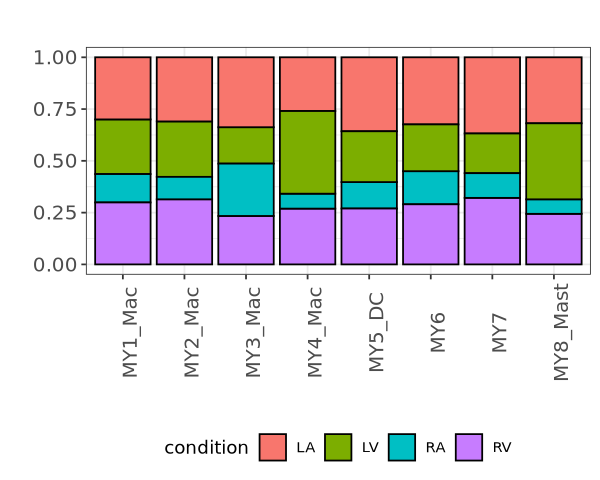

In [391]:
# Plot one to steal the color scheme
ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
                theme_bw () +
                labs(y= "", x = "", title = paste("")) +
                geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
                theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                      axis.text.x = element_text(angle = 90),
                                 plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                      ,legend.position = "bottom")

In [367]:
# Proportions by condition
cell.sample = as.data.frame(table(adata$cell.sub_types, adata$condition))
colnames(cell.sample)[1] = "CellType"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)
# Merge results
cell.sample = merge(cell.sample, major.minor, by = "CellType")
# Define a set of colors
cell.sample$condition = factor(cell.sample$condition, levels = c('CONTROL',
            "ICM_NDM",
            'ICM_DM ',
            'NICM_NDM',
            'NICM_DM'))

colors <- c('CONTROL' = "#33a02c",
            "ICM_NDM" = "#ff7f00",
            'ICM_DM ' = "#e31a1c",
            'NICM_NDM' = "#1f78b4",
            'NICM_DM' = "#6a3d9a")

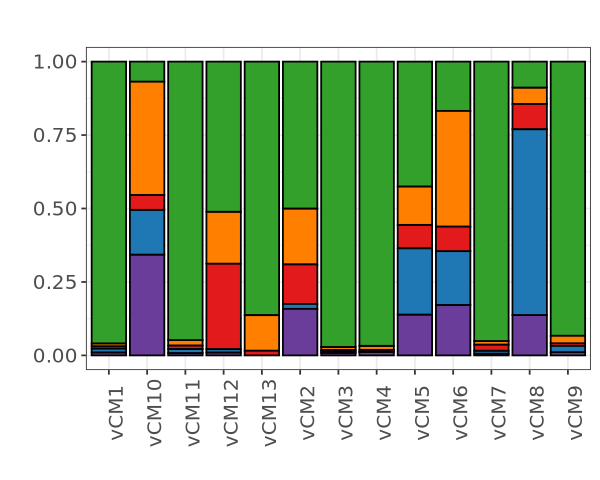

In [368]:
# Filter 
cell.use = "vCM"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

In [716]:
adata@meta.data %>%
  group_by(library) %>%
  summarise(median_counts = median(nCount_ATAC))

library,median_counts
<chr>,<dbl>
QY_2193_1_2_QY_2192_1_2,2473.0
QY_2195_1_2_QY_2194_1_2,2014.0
QY_2197_1_2_QY_2196_1_2,2093.0
QY_2199_1_2_QY_2198_1_2,2331.0
QY_2201_1_2_QY_2200_1_2,2119.0
QY_2203_1_2_QY_2202_1_2,2350.0
QY_2205_1_2_QY_2204_1_2,2354.0
QY_2207_1_2_QY_2206_1_2,2356.0
QY_2254_1_2_QY_2253_1_2,3792.0


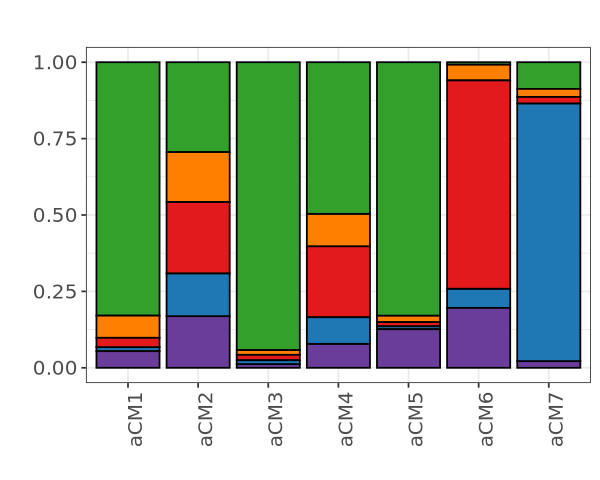

In [369]:
# Filter 
cell.use = "aCM"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

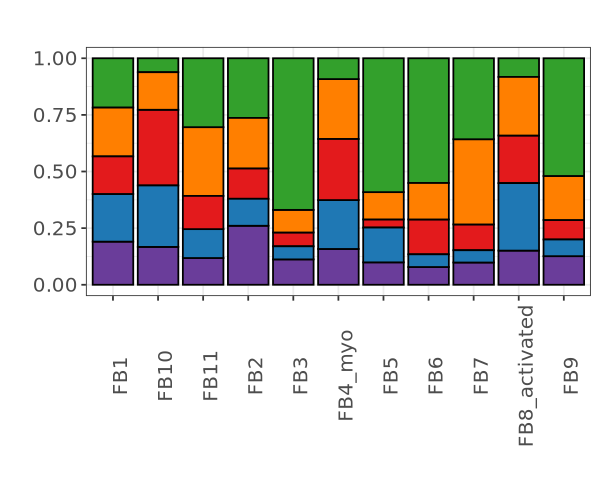

In [370]:
# Filter 
cell.use = "Fibroblast"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

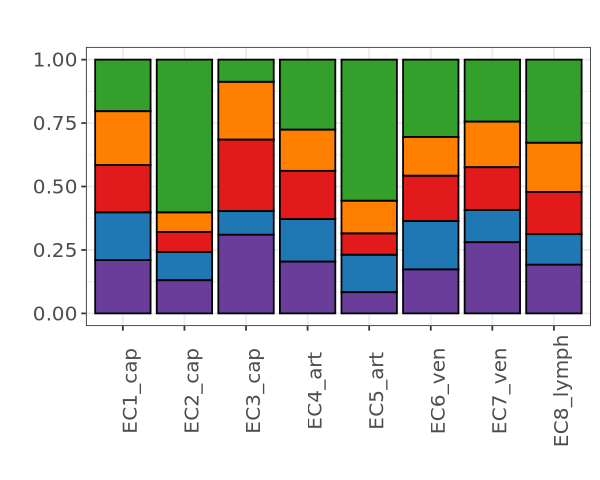

In [371]:
# Filter 
cell.use = "Endothelial"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

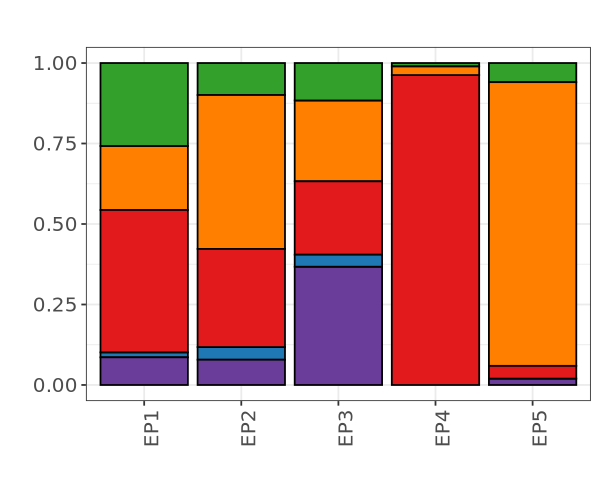

In [372]:
# Filter 
cell.use = "Epicardial"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

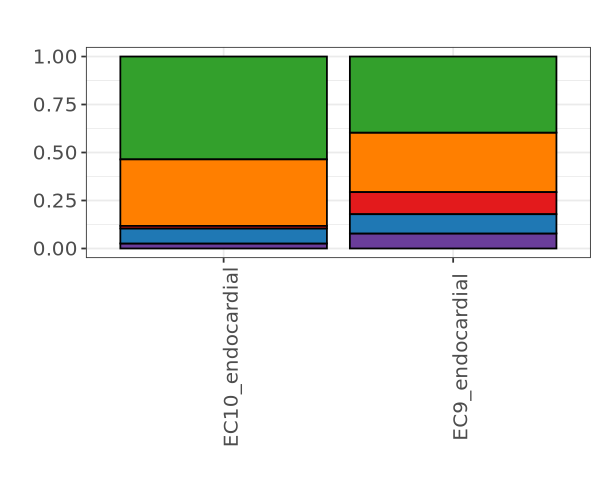

In [373]:
# Filter 
cell.use = "Endocardial"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

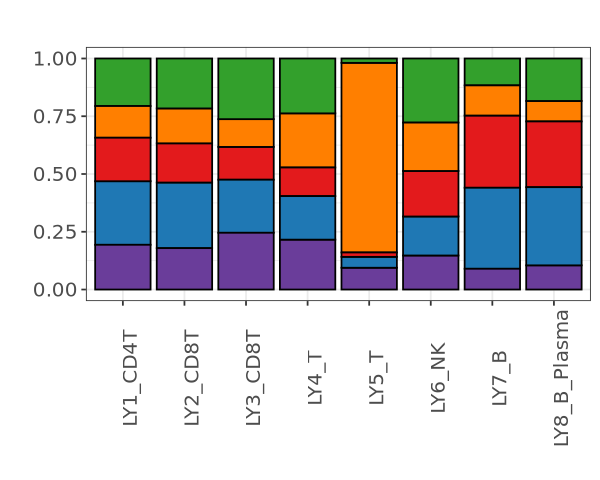

In [374]:
# Filter 
cell.use = "Lymphoid"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

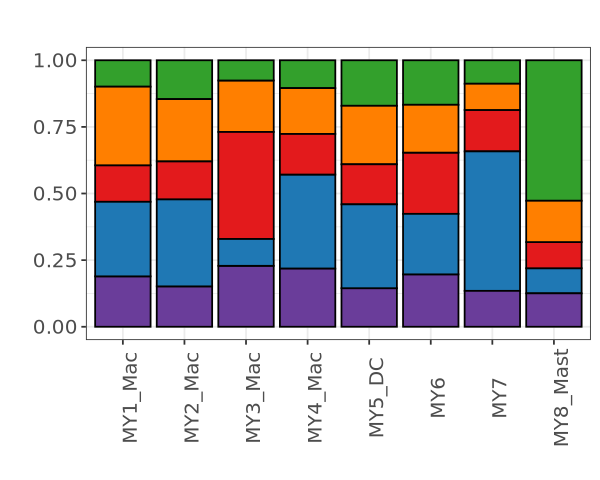

In [375]:
# Filter 
cell.use = "Myeloid"
cell.sample.plot = dplyr::filter(cell.sample, Lineage == cell.use)

# Plot
options(repr.plot.width=5, repr.plot.height=4)
gg = ggplot(cell.sample.plot, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  ,legend.position = "none")+
  scale_fill_manual(values = colors)

gg

file = paste0(cell.proportions.dir,
              cell.use, 
              "_ByCondition_CellProportions.pdf")

ggsave(filename = file, 
       plot = gg,
       device = "pdf",
       height = 4,
       width = 5)

In [21]:
# Proportions by condition
cell.sample = as.data.frame(table(adata$cell.sub_types, adata$biosample))
colnames(cell.sample)[1] = "CellType"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)
# Merge results
cell.sample = merge(cell.sample, major.minor, by = "CellType")
# Filter 
cell.sample = dplyr::filter(cell.sample, Lineage == "vCM")

# 
colors <- c("#33a02c", "#ff7f00", "#e31a1c", "#1f78b4", "#6a3d9a")
ggplot(cell.sample, aes(x= CellType, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Condition")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  , legend.position = "bottom")+
            coord_flip()

ERROR: Error in (function (cond) : error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': 'biosample' not found in this Seurat object
 


In [235]:
# Proportions by condition
cell.sample = as.data.frame(table(adata$cell.sub_types, adata$donor))
colnames(cell.sample)[1] = "CellType"
colnames(cell.sample)[2] = "donor"
cell.sample = dplyr::filter(cell.sample, Freq != 0)


In [344]:
# Merge results
cell.sample = merge(cell.sample, major.minor, by = "CellType")

# Proportions for Kyle

In [19]:
# Proportions by condition
cell.sample2 = as.data.frame(table(adata$cell.sub_types, adata$biosample))
colnames(cell.sample2)[1] = "CellType"
colnames(cell.sample2)[2] = "biosample"
cell.sample2 = dplyr::filter(cell.sample2, Freq != 0)

# Donor
meta = as.data.frame(table(adata$condition, adata$cell.sub_types, adata$donor))
colnames(meta) = c("condition", "celltype", "donor", "Freq")
cell_types <- unique(meta$celltype)
meta_wide <- pivot_wider(meta, 
                         names_from = celltype, 
                         values_from = Freq, 
                         id_cols = c(condition, donor))
meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])
# Define columns to compare
first.celltype = colnames(meta_wide[3])
last.celltype = colnames(meta_wide[ncol(meta_wide)])
message("comparing from: ", first.celltype, " to ", last.celltype)

# Normalize all celltypes by total_count (cell proportions by row)
cell.proportions1 <- meta_wide %>%
    dplyr::select(donor, condition, cell_types) %>%
    dplyr::rowwise() %>% 
    dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype))) %>% 
    dplyr::mutate(across(first.celltype:last.celltype, ~ .x / total_count))


# BIOSAMPLE
meta = as.data.frame(table(adata$condition, adata$cell.sub_types, adata$biosample))
colnames(meta) = c("condition", "celltype", "donor", "Freq")
cell_types <- unique(meta$celltype)
meta_wide <- pivot_wider(meta, 
                         names_from = celltype, 
                         values_from = Freq, 
                         id_cols = c(condition, donor))
meta_wide <- as.data.frame(meta_wide[rowSums(meta_wide[, 3:ncol(meta_wide)]) > 0, ])
# Define columns to compare
first.celltype = colnames(meta_wide[3])
last.celltype = colnames(meta_wide[ncol(meta_wide)])
message("comparing from: ", first.celltype, " to ", last.celltype)

# Normalize all celltypes by total_count (cell proportions by row)
cell.proportions2 <- meta_wide %>%
    dplyr::select(donor, condition, cell_types) %>%
    dplyr::rowwise() %>% 
    dplyr::mutate(total_count = sum(c_across(first.celltype:last.celltype))) %>% 
    dplyr::mutate(across(first.celltype:last.celltype, ~ .x / total_count)) %>%
    dplyr::mutate(chamber = str_split_fixed(donor, "--", n = 2)[,1])

cell.proportions2 = dplyr::filter(cell.proportions2, chamber == "LV")

ERROR: Error in (function (cond) : error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': 'biosample' not found in this Seurat object
 


In [20]:
head(cell.proportions1)
head(cell.proportions2)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'cell.proportions1' not found


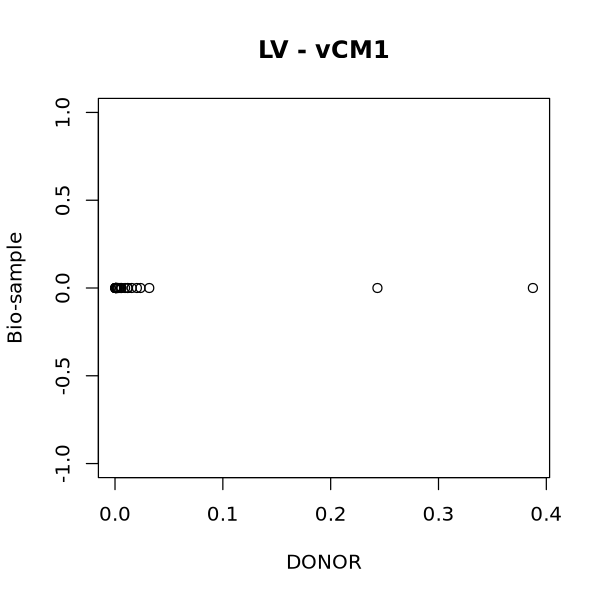

In [343]:
# Plot with x and y labels
plot(x = cell.proportions1$vCM1, 
     y = cell.proportions2$aCM1, 
     xlab = "DONOR", 
     ylab = "Bio-sample", 
     main = "LV - vCM1")

# Violin Plots for features

In [14]:
data.sub = subset(adata, cell.major_types == "vCM")

In [15]:
colnames(data.sub@meta.data)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "nCount_SCT"                        "nFeature_SCT"                     
[11] "SCT.weight"                        "ATAC.weight"                      
[13] "wsnn_res.0.2"                      "seurat_clusters"                  
[15] "log_nCount_ATAC"                   "log_nCount_SCT"                   
[17] "log_nFeature_ATAC"                 "log_nFeature_SCT"                 
[19] "wsnn_res.0.25"                     "library"                          
[21] "gex_raw_reads"                     "gex_mapped_reads"                 
[23] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[25] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[27] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[29] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[31] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[33] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[35] "gex_umis_count"                    "gex_genes_count"                  
[37] "atac_raw_reads"                    "atac_unmapped_reads"              
[39] "atac_lowmapq"                      "atac_dup_reads"                   
[41] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[43] "atac_fragments"                    "atac_TSS_fragments"               
[45] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[47] "donor"                             "chamber"                          
[49] "condition"                         "disease_status_major"             
[51] "disease_status_sub"                "diabetes_status"                  
[53] "age"                               "sex"                              
[55] "height"                            "weight"                           
[57] "BMI"                               "BMI.scaled"                       
[59] "weight.scaled"                     "height.scaled"                    
[61] "age.scaled"                        "TSS.enrichment"                   
[63] "TSS.percentile"                    "wsnn_res.0.5"                     
[65] "sil.qc"                            "cluster_sil.qc"                   
[67] "wsnn_res.0.6"                      "wsnn_res.1"                       
[69] "cell.major_types"                  "cell.sub_types"                   
[71] "cell.sub_types_disease"            "barcode"                          
[73] "gex_barcode"                       "atac_barcode"                     
[75] "is_cell"                           "excluded_reason"                  
[77] "chamber_major"                     "cell.sub_types_LUCA"              
[79] "cell.sub_types_chamber"            "cell.major_types_chamber"

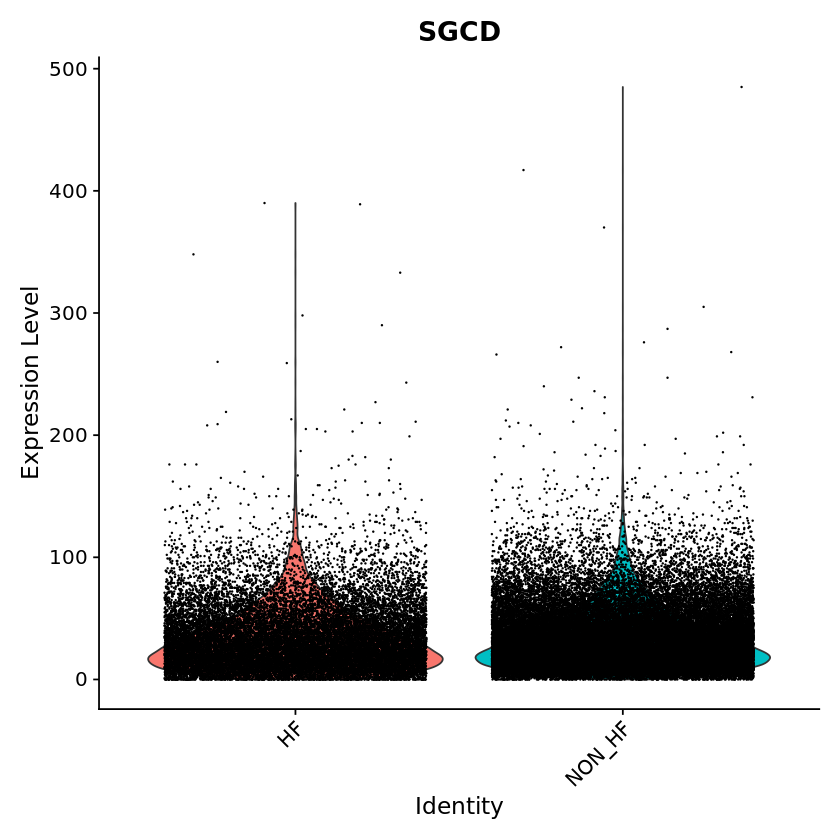

In [16]:
VlnPlot(data.sub,
        features = "SGCD", group.by = "disease_status_major",
        assay = "RNA") & NoLegend()

# Print percentage of expression per celltype per gene

In [706]:
Idents(adata) = adata$cell.major_types

In [703]:
# Get the expression data for all genes
expr_data <- GetAssayData(adata, slot = "data", assay = "RNA")

# Initialize an empty list to store results
results <- list()

# Loop through each cell type
for (cell_type in unique(Idents(adata))) {
  
  # Subset Seurat object to the specific cell type
  cells_in_type <- WhichCells(adata, ident = cell_type)
  
  # Subset expression data to these cells
  expr_data_subset <- expr_data[, cells_in_type]
  
  # Calculate the percentage of cells expressing each gene (non-zero expression)
  pct_expressing <- rowSums(expr_data_subset > 0) / length(cells_in_type) * 100
  
  # Store the results for this cell type
  results[[cell_type]] <- pct_expressing
}

# Combine results into a data frame
df_results <- do.call(cbind, results)
rownames(df_results) <- rownames(expr_data)  # Gene names
colnames(df_results) <- unique(Idents(adata))  # Cell type names

# Convert to a data frame and view the results
df_results <- as.data.frame(df_results)

# View the results
head(df_results)

# save the results to a file
write.csv(df_results,
          "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/RNA/4Chambers/MajorCelltypes_percent_expressing_all_genes.csv")

,Fibroblast,Endothelial,vCM,Myeloid,Pericyte,Endocardial,Lymphoid,SM,Neuronal,Adipocyte,Epicardial,aCM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIR1302-2HG,0.002978096,0.003727866,0.021914126,0.01168338,0.0000000,0.01120197,0.000000000,0.0000000,0.00000000,0.00000000,0.05827506,0.025161453
FAM138A,0.000000000,0.000000000,0.000000000,0.00000000,0.0000000,0.00000000,0.000000000,0.0000000,0.00000000,0.00000000,0.00000000,0.000000000
OR4F5,0.001489048,0.003727866,0.002921883,0.00194723,0.0000000,0.00000000,0.004994756,0.0000000,0.02523978,0.00000000,0.00000000,0.004193575
AL627309.1,0.318656283,0.177073625,0.669111309,0.64648038,0.1067188,0.56009858,0.174816443,0.3353147,0.32811711,1.15864528,0.99067599,0.859682966
AL627309.3,0.011912384,0.003727866,0.112492513,0.00584169,0.0000000,0.00000000,0.000000000,0.0000000,0.00000000,0.08912656,0.00000000,0.004193575
AL627309.2,0.000000000,0.000000000,0.001460942,0.00389446,0.0000000,0.00000000,0.004994756,0.0000000,0.00000000,0.08912656,0.00000000,0.004193575


In [708]:
Idents(adata) = adata$cell.sub_types
unique(Idents(adata))

[1] FB4_myo          EC2_cap          vCM7             EC7_ven         
 [5] FB2              MY1_Mac          EC4_art          PC1             
 [9] vCM6             MY2_Mac          EC1_cap          vCM4            
[13] vCM11            FB5              FB1              vCM1            
[17] vCM10            vCM2             MY8_Mast         EC9_endocardial 
[21] FB3              FB8_activated    vCM9             LY2_CD8T        
[25] PC4              EC6_ven          vCM5             SMC1            
[29] MY5_DC           vCM3             MY3_Mac          LY7_B           
[33] NC1              vCM8             LY1_CD4T         SMC2            
[37] LY6_NK           PC2              FB7              PC5             
[41] EC8_lymph        LY3_CD8T         LY8_B_Plasma     vCM12           
[45] PC3              NC2              MY6              MY4_Mac         
[49] EC3_cap          FB10             AD1              LY4_T           
[53] FB6              NC3              EC5_art          EP1             
[57] FB11             FB9              MY7              AD3             
[61] EP4              vCM13            PC6              EP3             
[65] EP2              EC10_endocardial AD2              NC4             
[69] LY5_T            EP5              aCM2             aCM1            
[73] aCM4             aCM5             aCM3             aCM6            
[77] aCM7            
77 Levels: FB4_myo EC2_cap vCM7 EC7_ven FB2 MY1_Mac EC4_art PC1 ... aCM7

In [709]:
# Get the expression data for all genes
expr_data <- GetAssayData(adata, slot = "data", assay = "RNA")

# Initialize an empty list to store results
results <- list()

# Loop through each cell type
for (cell_type in unique(Idents(adata))) {
  
  # Subset Seurat object to the specific cell type
  cells_in_type <- WhichCells(adata, ident = cell_type)
  
  # Subset expression data to these cells
  expr_data_subset <- expr_data[, cells_in_type]
  
  # Calculate the percentage of cells expressing each gene (non-zero expression)
  pct_expressing <- rowSums(expr_data_subset > 0) / length(cells_in_type) * 100
  
  # Store the results for this cell type
  results[[cell_type]] <- pct_expressing
}

# Combine results into a data frame
df_results <- do.call(cbind, results)
rownames(df_results) <- rownames(expr_data)  # Gene names
colnames(df_results) <- unique(Idents(adata))  # Cell type names

# Convert to a data frame and view the results
df_results <- as.data.frame(df_results)

# View the results
head(df_results)

# save the results to a file
write.csv(df_results,
          "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/RNA/4Chambers/CellSubtypes_percent_expressing_all_genes.csv")

,FB4_myo,EC2_cap,vCM7,EC7_ven,FB2,MY1_Mac,EC4_art,PC1,vCM6,MY2_Mac,⋯,NC4,LY5_T,EP5,aCM2,aCM1,aCM4,aCM5,aCM3,aCM6,aCM7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIR1302-2HG,0.00000000,0.0000000,0.02342469,0.02143623,0.007154099,0.000000000,0.00000000,0.0000000,0.01666944,0.01745810,⋯,0,0.0000000,0.000000,0.01903312,0.02718869,0.03137747,0.0000000,0.02453988,0.0000000,0.1455604
FAM138A,0.00000000,0.0000000,0.00000000,0.00000000,0.000000000,0.000000000,0.00000000,0.0000000,0.00000000,0.00000000,⋯,0,0.0000000,0.000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,0.0000000
OR4F5,0.00000000,0.0000000,0.00000000,0.00000000,0.000000000,0.006892749,0.01183012,0.0000000,0.00000000,0.00000000,⋯,0,0.0000000,0.000000,0.00000000,0.00000000,0.00000000,0.0000000,0.02453988,0.0000000,0.0000000
AL627309.1,0.30618494,0.1232708,0.58561724,0.45016077,0.250393475,0.406672181,0.17745179,0.1205909,0.85014169,0.89909218,⋯,0,0.9433962,3.960396,0.70422535,1.08754758,1.03545654,0.5620406,0.63803681,0.9240246,1.0189229
AL627309.3,0.03061849,0.0000000,0.04684938,0.00000000,0.007154099,0.013785498,0.01183012,0.0000000,0.08334722,0.00000000,⋯,0,0.0000000,0.000000,0.00000000,0.00000000,0.00000000,0.0432339,0.00000000,0.0000000,0.0000000
AL627309.2,0.00000000,0.0000000,0.00000000,0.00000000,0.000000000,0.000000000,0.00000000,0.0000000,0.00000000,0.00872905,⋯,0,0.0000000,0.000000,0.00000000,0.00000000,0.03137747,0.0000000,0.00000000,0.0000000,0.0000000
